<a href="https://colab.research.google.com/github/younghoonNa/Penguin_Predict_DACON/blob/main/%ED%8E%AD%EA%B7%84_%EB%AA%B8%EB%AC%B4%EA%B2%8C_%EC%98%88%EC%B8%A1_DACON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#내 구글 드라이브로 마운트
from google.colab import drive
path = '/content/drive'
drive.mount(path)

Mounted at /content/drive


## 첫 데이콘 펭귄 시작 전 필요한 모듈 import

In [79]:
#기본 모듈은 numpy 그리고 pandas 사용.
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


#분류/Classifier 사용에 필요한 모델 import 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

#Regressor에 필요한 모델 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


## 첫 데이콘 펭귄 가보자구~~~ EDA

In [8]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')
train.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
0,0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550
1,1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800
2,2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854,4400
3,3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,FEMALE,8.20106,-26.16524,4850
4,4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,MALE,8.38324,-26.84272,5700


In [9]:
test = pd.read_csv('/content/drive/MyDrive/test.csv')
test.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,0,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,52.0,20.7,210.0,MALE,9.43146,-24.68440
1,1,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,55.9,17.0,228.0,MALE,8.31180,-26.35425
2,2,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,38.9,18.8,190.0,FEMALE,8.36936,-26.11199
3,3,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,45.2,16.6,191.0,FEMALE,9.62357,-24.78984
4,4,Adelie Penguin (Pygoscelis adeliae),Biscoe,No,37.9,18.6,172.0,FEMALE,8.38404,-25.19837


In [10]:
sample_submission = pd.read_csv('/content/drive/MyDrive/penguin/sample_submission.csv')
sample_submission.head()

,id,Body Mass (g)
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   114 non-null    int64  
 1   Species              114 non-null    object 
 2   Island               114 non-null    object 
 3   Clutch Completion    114 non-null    object 
 4   Culmen Length (mm)   114 non-null    float64
 5   Culmen Depth (mm)    114 non-null    float64
 6   Flipper Length (mm)  114 non-null    int64  
 7   Sex                  111 non-null    object 
 8   Delta 15 N (o/oo)    111 non-null    float64
 9   Delta 13 C (o/oo)    111 non-null    float64
 10  Body Mass (g)        114 non-null    int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 9.9+ KB


In [12]:
train.isna().sum()

id                     0
Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    3
Delta 15 N (o/oo)      3
Delta 13 C (o/oo)      3
Body Mass (g)          0
dtype: int64

In [13]:
train['Sex'].value_counts()

MALE      56
FEMALE    55
Name: Sex, dtype: int64

## Train 데이터 One-Hot 

In [14]:
print(train['Species'].value_counts() , '\n')
print(train['Island'].value_counts(), '\n')
print(train['Clutch Completion'].value_counts(), '\n')

Gentoo penguin (Pygoscelis papua)            48
Adelie Penguin (Pygoscelis adeliae)          41
Chinstrap penguin (Pygoscelis antarctica)    25
Name: Species, dtype: int64 

Biscoe       57
Dream        44
Torgersen    13
Name: Island, dtype: int64 

Yes    102
No      12
Name: Clutch Completion, dtype: int64 



In [15]:
Species_dummmies = pd.get_dummies(train['Species'])
Island_dummmies = pd.get_dummies(train['Island'])
Clutch_dummmies = pd.get_dummies(train['Clutch Completion'])
#기존의 방법은 Sex_data를 보간 X해주고 그냥 남성으로 채움 -> 보간법을 통해 채워줌.
#Sex_dummmies = pd.get_dummies(train['Sex'])

train = pd.concat((train, Species_dummmies), axis=1)
train = pd.concat((train, Island_dummmies), axis=1)
train = pd.concat((train, Clutch_dummmies), axis=1)

#features라는 리스트를 사용하기 때문에 필요가 없어짐.
# train = pd.concat((train, Sex_dummmies), axis=1)
# train = train.drop(['Species', 'Island', 'Clutch Completion'], axis = 1)

train.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g),Adelie Penguin (Pygoscelis adeliae),Chinstrap penguin (Pygoscelis antarctica),Gentoo penguin (Pygoscelis papua),Biscoe,Dream,Torgersen,No,Yes
0,0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550,0,0,1,1,0,0,0,1
1,1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800,0,1,0,0,1,0,1,0
2,2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854,4400,0,0,1,1,0,0,0,1
3,3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,FEMALE,8.20106,-26.16524,4850,0,0,1,1,0,0,0,1
4,4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,MALE,8.38324,-26.84272,5700,0,0,1,1,0,0,1,0


### Delta 13 C (o/oo) & Delta 15 N (o/oo) NA값 채우기


In [16]:
train.loc[train['Delta 13 C (o/oo)'].isna() == True, :]
train.loc[train['Delta 13 C (o/oo)'].isna() == True, 'Delta 13 C (o/oo)'] = train['Delta 13 C (o/oo)'].median()
train.loc[train['Delta 15 N (o/oo)'].isna() == True, 'Delta 15 N (o/oo)'] = train['Delta 15 N (o/oo)'].median()

## NA 값을 보간법으로 처리해보장.

### 우선 ['Sex'] 데이터만 뽑아서 데이터 만들기.

In [17]:
sex_data = train.loc[train['Sex'].notna() == True]
sex_data.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g),Adelie Penguin (Pygoscelis adeliae),Chinstrap penguin (Pygoscelis antarctica),Gentoo penguin (Pygoscelis papua),Biscoe,Dream,Torgersen,No,Yes
0,0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550,0,0,1,1,0,0,0,1
1,1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800,0,1,0,0,1,0,1,0
2,2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854,4400,0,0,1,1,0,0,0,1
3,3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,FEMALE,8.20106,-26.16524,4850,0,0,1,1,0,0,0,1
4,4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,MALE,8.38324,-26.84272,5700,0,0,1,1,0,0,1,0


In [18]:
na_sex_data = train.loc[train['Sex'].isna() == True]
na_sex_data

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g),Adelie Penguin (Pygoscelis adeliae),Chinstrap penguin (Pygoscelis antarctica),Gentoo penguin (Pygoscelis papua),Biscoe,Dream,Torgersen,No,Yes
6,6,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,42.0,20.2,190,NaN,9.13362,-25.09368,4250,1,0,0,0,0,1,0,1
8,8,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,34.1,18.1,193,NaN,8.63259,-25.95541,3475,1,0,0,0,0,1,0,1
70,70,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,46.2,14.4,214,NaN,8.24253,-26.81540,4650,0,0,1,1,0,0,0,1


In [19]:
sex_data.isna().sum()

id                                           0
Species                                      0
Island                                       0
Clutch Completion                            0
Culmen Length (mm)                           0
Culmen Depth (mm)                            0
Flipper Length (mm)                          0
Sex                                          0
Delta 15 N (o/oo)                            0
Delta 13 C (o/oo)                            0
Body Mass (g)                                0
Adelie Penguin (Pygoscelis adeliae)          0
Chinstrap penguin (Pygoscelis antarctica)    0
Gentoo penguin (Pygoscelis papua)            0
Biscoe                                       0
Dream                                        0
Torgersen                                    0
No                                           0
Yes                                          0
dtype: int64

In [20]:
sex_data.loc[sex_data['Sex'] == 'MALE', 'Sex'] = 1
sex_data.loc[sex_data['Sex'] == 'FEMALE', 'Sex'] = 0

sex_data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g),Adelie Penguin (Pygoscelis adeliae),Chinstrap penguin (Pygoscelis antarctica),Gentoo penguin (Pygoscelis papua),Biscoe,Dream,Torgersen,No,Yes
0,0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,1,8.30515,-25.19017,5550,0,0,1,1,0,0,0,1
1,1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,1,9.63074,-24.34684,3800,0,1,0,0,1,0,1,0
2,2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,0,8.51951,-27.01854,4400,0,0,1,1,0,0,0,1
3,3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,0,8.20106,-26.16524,4850,0,0,1,1,0,0,0,1
4,4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,1,8.38324,-26.84272,5700,0,0,1,1,0,0,1,0


In [21]:
sex_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111 entries, 0 to 113
Data columns (total 19 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         111 non-null    int64  
 1   Species                                    111 non-null    object 
 2   Island                                     111 non-null    object 
 3   Clutch Completion                          111 non-null    object 
 4   Culmen Length (mm)                         111 non-null    float64
 5   Culmen Depth (mm)                          111 non-null    float64
 6   Flipper Length (mm)                        111 non-null    int64  
 7   Sex                                        111 non-null    object 
 8   Delta 15 N (o/oo)                          111 non-null    float64
 9   Delta 13 C (o/oo)                          111 non-null    float64
 10  Body Mass (g)             

In [22]:
#sex type 변경 
sex_data = sex_data.astype({'Sex' : 'int64'})
sex_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111 entries, 0 to 113
Data columns (total 19 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         111 non-null    int64  
 1   Species                                    111 non-null    object 
 2   Island                                     111 non-null    object 
 3   Clutch Completion                          111 non-null    object 
 4   Culmen Length (mm)                         111 non-null    float64
 5   Culmen Depth (mm)                          111 non-null    float64
 6   Flipper Length (mm)                        111 non-null    int64  
 7   Sex                                        111 non-null    int64  
 8   Delta 15 N (o/oo)                          111 non-null    float64
 9   Delta 13 C (o/oo)                          111 non-null    float64
 10  Body Mass (g)             

In [23]:
#지역, 펭귄 종류는 관련이 없으므로 수치형 데이터만 가져옵니다.
features_sex = [
    'Culmen Length (mm)',
    'Culmen Depth (mm)',
    'Flipper Length (mm)',
    'Delta 15 N (o/oo)',
    'Delta 13 C (o/oo)',
]

features_sex

['Culmen Length (mm)',
 'Culmen Depth (mm)',
 'Flipper Length (mm)',
 'Delta 15 N (o/oo)',
 'Delta 13 C (o/oo)']

In [24]:
train_sex = sex_data[features_sex]
train_sex.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo)
0,50.0,15.3,220,8.30515,-25.19017
1,49.5,19.0,200,9.63074,-24.34684
2,45.1,14.4,210,8.51951,-27.01854
3,44.5,14.7,214,8.20106,-26.16524
4,49.6,16.0,225,8.38324,-26.84272


In [25]:
test_sex = sex_data['Sex']
test_sex

0      1
1      1
2      0
3      0
4      1
      ..
109    0
110    1
111    1
112    0
113    1
Name: Sex, Length: 111, dtype: int64

In [26]:
# train 및 test 데이터 분할
x_train_sex, x_test_sex, y_train_sex, y_test_sex = train_test_split(train_sex, test_sex, random_state=23, test_size=0.1)

In [27]:
# LogisticClassifier(), -> continuous에러 / LogisticClassifier -> 따라서 이번에는 제거해줌.
models=[RandomForestClassifier(), KNeighborsClassifier(), BaggingClassifier(), GradientBoostingClassifier(), XGBClassifier(), LGBMClassifier(),
        AdaBoostClassifier(),  SVC()
        ]
     
model_names=['RandomForest', 'KNeighbors', 'Bagging', 'GradientBoosting', 'XGB', 'LGBM',
             'AdaBoost', 'SVC',
          ]

for model in range (len(models)):
    clf=models[model]
    clf.fit(x_train_sex,y_train_sex)
    test_pred=clf.predict(x_test_sex)

    y_test_sex = np.array(y_test_sex)
    print(models[model])
    print(test_pred - y_test_sex)


RandomForestClassifier()
[0 0 0 0 0 0 1 0 0 0 0 0]
KNeighborsClassifier()
[ 0  0 -1  0  0  0  0  0  0  0  0 -1]
BaggingClassifier()
[0 0 0 0 0 0 1 0 0 0 0 0]
GradientBoostingClassifier()
[0 0 0 0 0 0 1 0 0 0 0 0]
XGBClassifier()
[0 0 0 0 0 0 1 0 0 0 0 0]
LGBMClassifier()
[0 0 0 0 0 0 0 0 0 0 0 0]
AdaBoostClassifier()
[ 0  0 -1  1  0  0  0  0  0  0  0  0]
SVC()
[1 0 0 1 0 0 1 0 0 0 0 0]


In [28]:
#RandomForestClassifier / LGBMClassifier
model_na_lgbm = LGBMClassifier().fit(train_sex, test_sex)
model_na_lgbm.predict(na_sex_data[features_sex])

array([1, 1, 0])

In [29]:
train.loc[train['Sex'].isna() == True, 'Sex']

6     NaN
8     NaN
70    NaN
Name: Sex, dtype: object

In [30]:
train.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g),Adelie Penguin (Pygoscelis adeliae),Chinstrap penguin (Pygoscelis antarctica),Gentoo penguin (Pygoscelis papua),Biscoe,Dream,Torgersen,No,Yes
0,0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550,0,0,1,1,0,0,0,1
1,1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800,0,1,0,0,1,0,1,0
2,2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854,4400,0,0,1,1,0,0,0,1
3,3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,FEMALE,8.20106,-26.16524,4850,0,0,1,1,0,0,0,1
4,4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,MALE,8.38324,-26.84272,5700,0,0,1,1,0,0,1,0


In [31]:
train['Sex'][6] = "MALE"
train['Sex'][8] = "MALE"
train['Sex'][70] = "FEMALE"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

In [32]:
train.isna().sum()

id                                           0
Species                                      0
Island                                       0
Clutch Completion                            0
Culmen Length (mm)                           0
Culmen Depth (mm)                            0
Flipper Length (mm)                          0
Sex                                          0
Delta 15 N (o/oo)                            0
Delta 13 C (o/oo)                            0
Body Mass (g)                                0
Adelie Penguin (Pygoscelis adeliae)          0
Chinstrap penguin (Pygoscelis antarctica)    0
Gentoo penguin (Pygoscelis papua)            0
Biscoe                                       0
Dream                                        0
Torgersen                                    0
No                                           0
Yes                                          0
dtype: int64

## Test 데이터 보간하기

In [33]:
test.isna().sum()

id                     0
Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    6
Delta 15 N (o/oo)      9
Delta 13 C (o/oo)      8
dtype: int64

In [34]:
#너네는 귀차나..
test.loc[test['Delta 13 C (o/oo)'].isna() == True, 'Delta 13 C (o/oo)'] = test['Delta 13 C (o/oo)'].median()
test.loc[test['Delta 15 N (o/oo)'].isna() == True, 'Delta 15 N (o/oo)'] = test['Delta 15 N (o/oo)'].median()

In [35]:
test.isna().sum()

id                     0
Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    6
Delta 15 N (o/oo)      0
Delta 13 C (o/oo)      0
dtype: int64

In [36]:
Species_dummmies = pd.get_dummies(test['Species'])
Island_dummmies = pd.get_dummies(test['Island'])
Clutch_dummmies = pd.get_dummies(test['Clutch Completion'])
# Sex_dummmies = pd.get_dummies(test['Sex'])

test = pd.concat((test, Species_dummmies), axis=1)
test = pd.concat((test, Island_dummmies), axis=1)
test = pd.concat((test, Clutch_dummmies), axis=1)
# test = pd.concat((test, Sex_dummmies), axis=1)
# test = test.drop(['Species', 'Island', 'Clutch Completion'], axis = 1)

test.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Adelie Penguin (Pygoscelis adeliae),Chinstrap penguin (Pygoscelis antarctica),Gentoo penguin (Pygoscelis papua),Biscoe,Dream,Torgersen,No,Yes
0,0,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,52.0,20.7,210.0,MALE,9.43146,-24.68440,0,1,0,0,1,0,0,1
1,1,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,55.9,17.0,228.0,MALE,8.31180,-26.35425,0,0,1,1,0,0,0,1
2,2,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,38.9,18.8,190.0,FEMALE,8.36936,-26.11199,1,0,0,0,1,0,0,1
3,3,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,45.2,16.6,191.0,FEMALE,9.62357,-24.78984,0,1,0,0,1,0,0,1
4,4,Adelie Penguin (Pygoscelis adeliae),Biscoe,No,37.9,18.6,172.0,FEMALE,8.38404,-25.19837,1,0,0,1,0,0,1,0


In [37]:
test_na_sex = test.loc[test['Sex'].isna()==True, :]
test_na_sex

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Adelie Penguin (Pygoscelis adeliae),Chinstrap penguin (Pygoscelis antarctica),Gentoo penguin (Pygoscelis papua),Biscoe,Dream,Torgersen,No,Yes
46,46,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,37.8,17.1,186.0,NaN,8.63243,-25.21315,1,0,0,0,0,1,0,1
81,81,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,37.5,18.9,179.0,NaN,8.67538,-25.80610,1,0,0,0,1,0,0,1
98,98,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,47.3,13.8,216.0,NaN,8.25818,-26.23886,0,0,1,1,0,0,0,1
152,152,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,15.7,217.0,NaN,8.04111,-26.18444,0,0,1,1,0,0,0,1
205,205,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,37.8,17.3,180.0,NaN,8.67538,-25.80610,1,0,0,0,0,1,0,1
209,209,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.3,216.0,NaN,7.96621,-25.69327,0,0,1,1,0,0,0,1


In [38]:
model_na_lgbm.predict(test_na_sex[features_sex])

array([0, 1, 0, 0, 0, 0])

In [39]:
test['Sex'][46] = "FEMALE"
test['Sex'][81] = "MALE"
test['Sex'][98] = "FEMALE"
test['Sex'][152] = "FEMALE"
test['Sex'][205] = "FEMALE"
test['Sex'][209] = "FEMALE"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

In [40]:
test.isna().sum()

id                                           0
Species                                      0
Island                                       0
Clutch Completion                            0
Culmen Length (mm)                           0
Culmen Depth (mm)                            0
Flipper Length (mm)                          0
Sex                                          0
Delta 15 N (o/oo)                            0
Delta 13 C (o/oo)                            0
Adelie Penguin (Pygoscelis adeliae)          0
Chinstrap penguin (Pygoscelis antarctica)    0
Gentoo penguin (Pygoscelis papua)            0
Biscoe                                       0
Dream                                        0
Torgersen                                    0
No                                           0
Yes                                          0
dtype: int64

# 데이터 시각화 

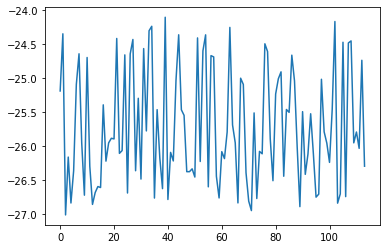

In [41]:
import matplotlib.pyplot as plt
plt.plot(train['Delta 13 C (o/oo)'])

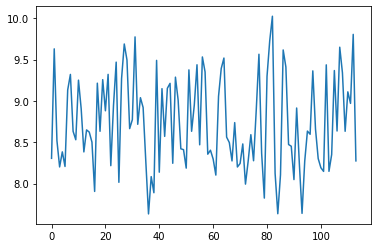

In [42]:
import matplotlib.pyplot as plt
plt.plot(train['Delta 15 N (o/oo)'])

In [43]:
train.describe()

,id,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g),Adelie Penguin (Pygoscelis adeliae),Chinstrap penguin (Pygoscelis antarctica),Gentoo penguin (Pygoscelis papua),Biscoe,Dream,Torgersen,No,Yes
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,56.500000,44.613158,17.014912,203.052632,8.734870,-25.729166,4327.850877,0.359649,0.219298,0.421053,0.500000,0.385965,0.114035,0.105263,0.894737
std,33.052988,5.321829,1.941363,14.653425,0.560366,0.849119,781.766484,0.482016,0.415598,0.495908,0.502208,0.488972,0.319257,0.308247,0.308247
min,0.000000,33.500000,13.200000,174.000000,7.632200,-27.018540,2700.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.250000,40.325000,15.225000,190.000000,8.273890,-26.414327,3675.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,56.500000,45.200000,17.250000,199.000000,8.632590,-25.955410,4250.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,1.000000
75%,84.750000,49.075000,18.600000,216.000000,9.256210,-25.012013,4850.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,113.000000,55.100000,21.100000,231.000000,10.025440,-24.102550,6300.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


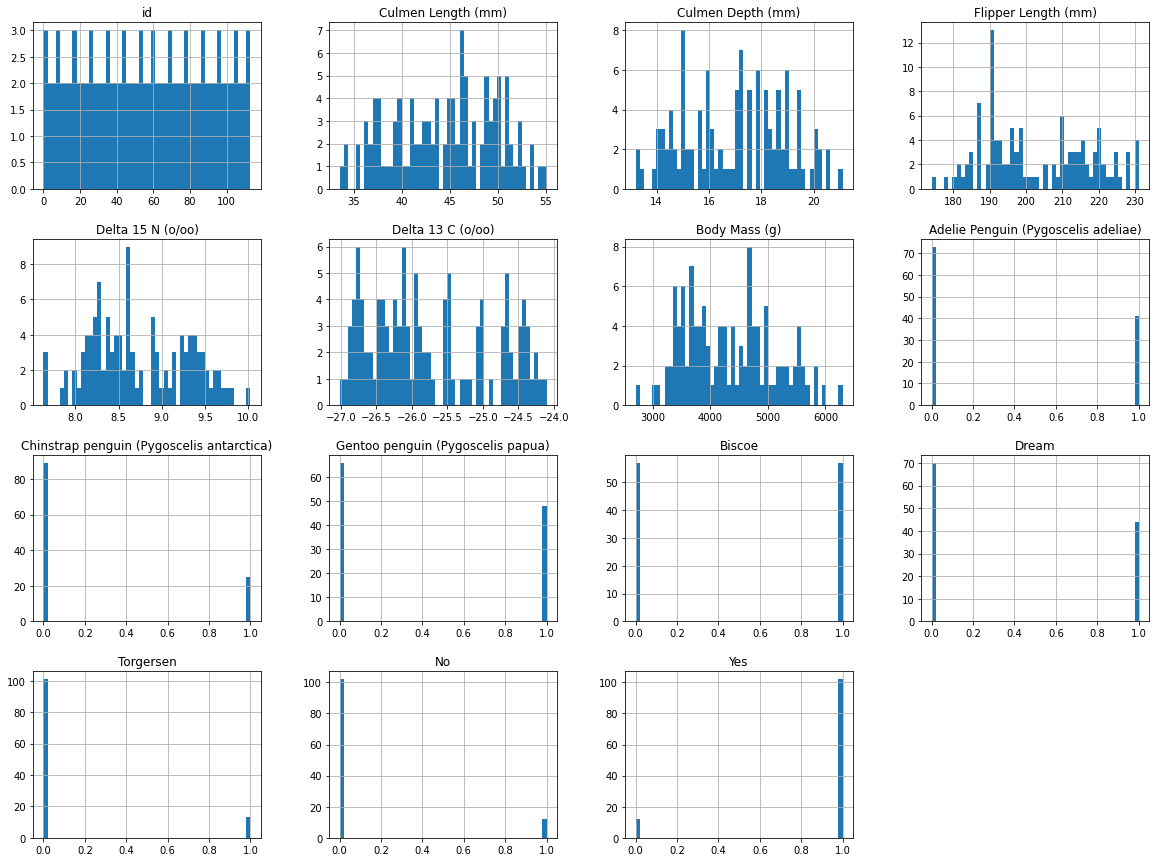

In [44]:
train.hist(bins=50, figsize=(20,15))
plt.show()

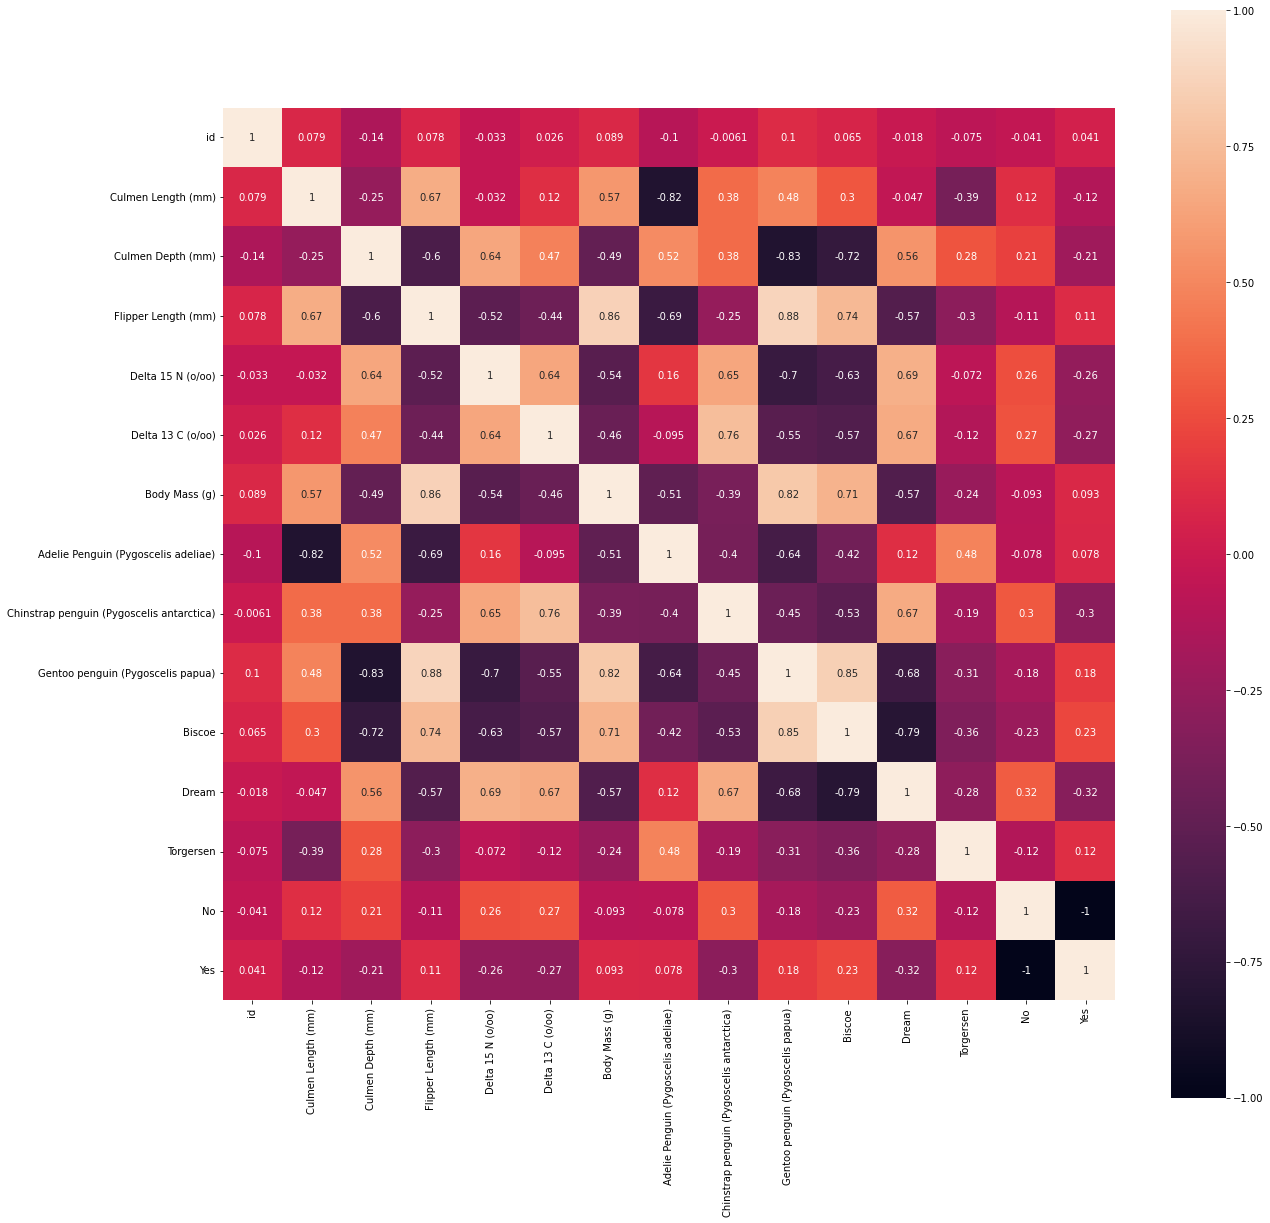

In [45]:
import seaborn as sns
plt.subplots(figsize=(20,20))
sns.heatmap(train.corr(), mask=np.zeros_like(train.corr(), dtype=bool),
            square=True, annot=True)
plt.show()

In [46]:
#'Body Mass (g)'
features = [
    'Culmen Length (mm)',
    'Culmen Depth (mm)',
    'Flipper Length (mm)',
    'Delta 15 N (o/oo)',
    'Delta 13 C (o/oo)',
    'Adelie Penguin (Pygoscelis adeliae)',
    'Chinstrap penguin (Pygoscelis antarctica)',
    'Gentoo penguin (Pygoscelis papua)', 
    'Biscoe',
    'Dream',
    'Torgersen',
    'FEMALE',
		'MALE',
]
features

['Culmen Length (mm)',
 'Culmen Depth (mm)',
 'Flipper Length (mm)',
 'Delta 15 N (o/oo)',
 'Delta 13 C (o/oo)',
 'Adelie Penguin (Pygoscelis adeliae)',
 'Chinstrap penguin (Pygoscelis antarctica)',
 'Gentoo penguin (Pygoscelis papua)',
 'Biscoe',
 'Dream',
 'Torgersen',
 'FEMALE',
 'MALE']

<font color = red> 아쉬운점 1, 지역까지 신경써서 분류 했더라면... </font>

In [47]:
# 몸무게에 많은 영향을 미치는 전투 펭귄에 대해 젠투 / 비젠투로 나눠봄 -> 별 의미 없더라... -> 지역까지 신경 썼으면 더 좋았을 텐데...
# 젠투 비젠투에 남 여 까지 합쳐서 모델링을 했더라면,, 좋은 결과가 나왔을거야.

# X['not_Gentoo'] = 0
# X.loc[X['Adelie Penguin (Pygoscelis adeliae)'] == 1, 'not_Gentoo'] = 1
# X.loc[X['Chinstrap penguin (Pygoscelis antarctica)'] == 1, 'not_Gentoo'] = 1

# X = X.drop(['Adelie Penguin (Pygoscelis adeliae)',
#                 'Chinstrap penguin (Pygoscelis antarctica)',
#                 'Gentoo penguin (Pygoscelis papua)'], axis=1)

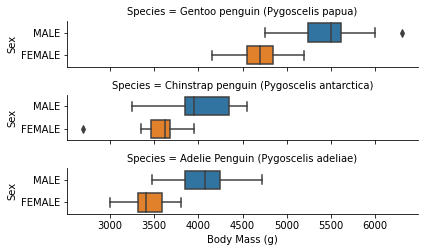

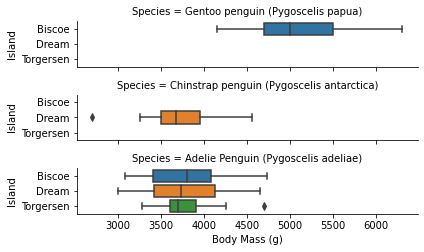

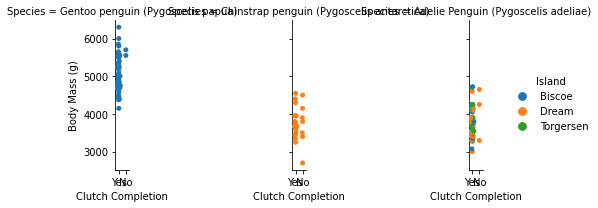

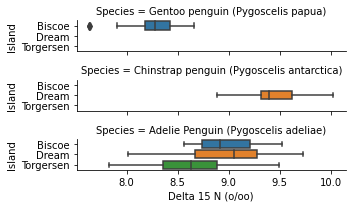

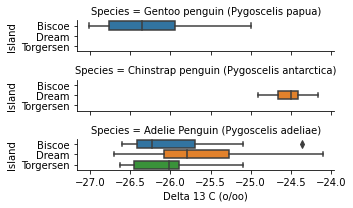

In [48]:
# 2.1.1. box plot (Species, Sex)에 따른 몸무게 데이터 분포 확인  
sns.catplot(x="Body Mass (g)", y="Sex", row="Species", 
            orient="h", height=1.2, aspect=5, 
            kind="box", data=train)


# 2.1.2 box plot (Species, island)에 따른 몸무게 데이터 분포 확인  
sns.catplot(x="Body Mass (g)", y="Island", row="Species", 
            orient="h", height=1.2, aspect=5, 
            kind="box", data=train)

# 2.1.3 swarm plot (Species, Clutch, island)에 따른 몸무게 데이터 분포 확인 
sns.catplot(x="Clutch Completion", y="Body Mass (g)", col="Species",
            hue="Island", height=3, aspect=0.7, 
            kind="swarm", data=train)

# 2.1.4 box plot (Species, island)에 따른 13_C, 15_N 데이터 분포 확인  
sns.catplot(x="Delta 15 N (o/oo)", y="Island", row="Species", 
            orient="h", height=1, aspect=5, 
            kind="box", data=train)
sns.catplot(x="Delta 13 C (o/oo)", y="Island", row="Species", 
            orient="h", height=1, aspect=5, 
            kind="box", data=train)

In [52]:
nur_train = train.select_dtypes(include=['int', 'float'])
nur_train.head()

,id,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
0,0,50.0,15.3,220,8.30515,-25.19017,5550
1,1,49.5,19.0,200,9.63074,-24.34684,3800
2,2,45.1,14.4,210,8.51951,-27.01854,4400
3,3,44.5,14.7,214,8.20106,-26.16524,4850
4,4,49.6,16.0,225,8.38324,-26.84272,5700


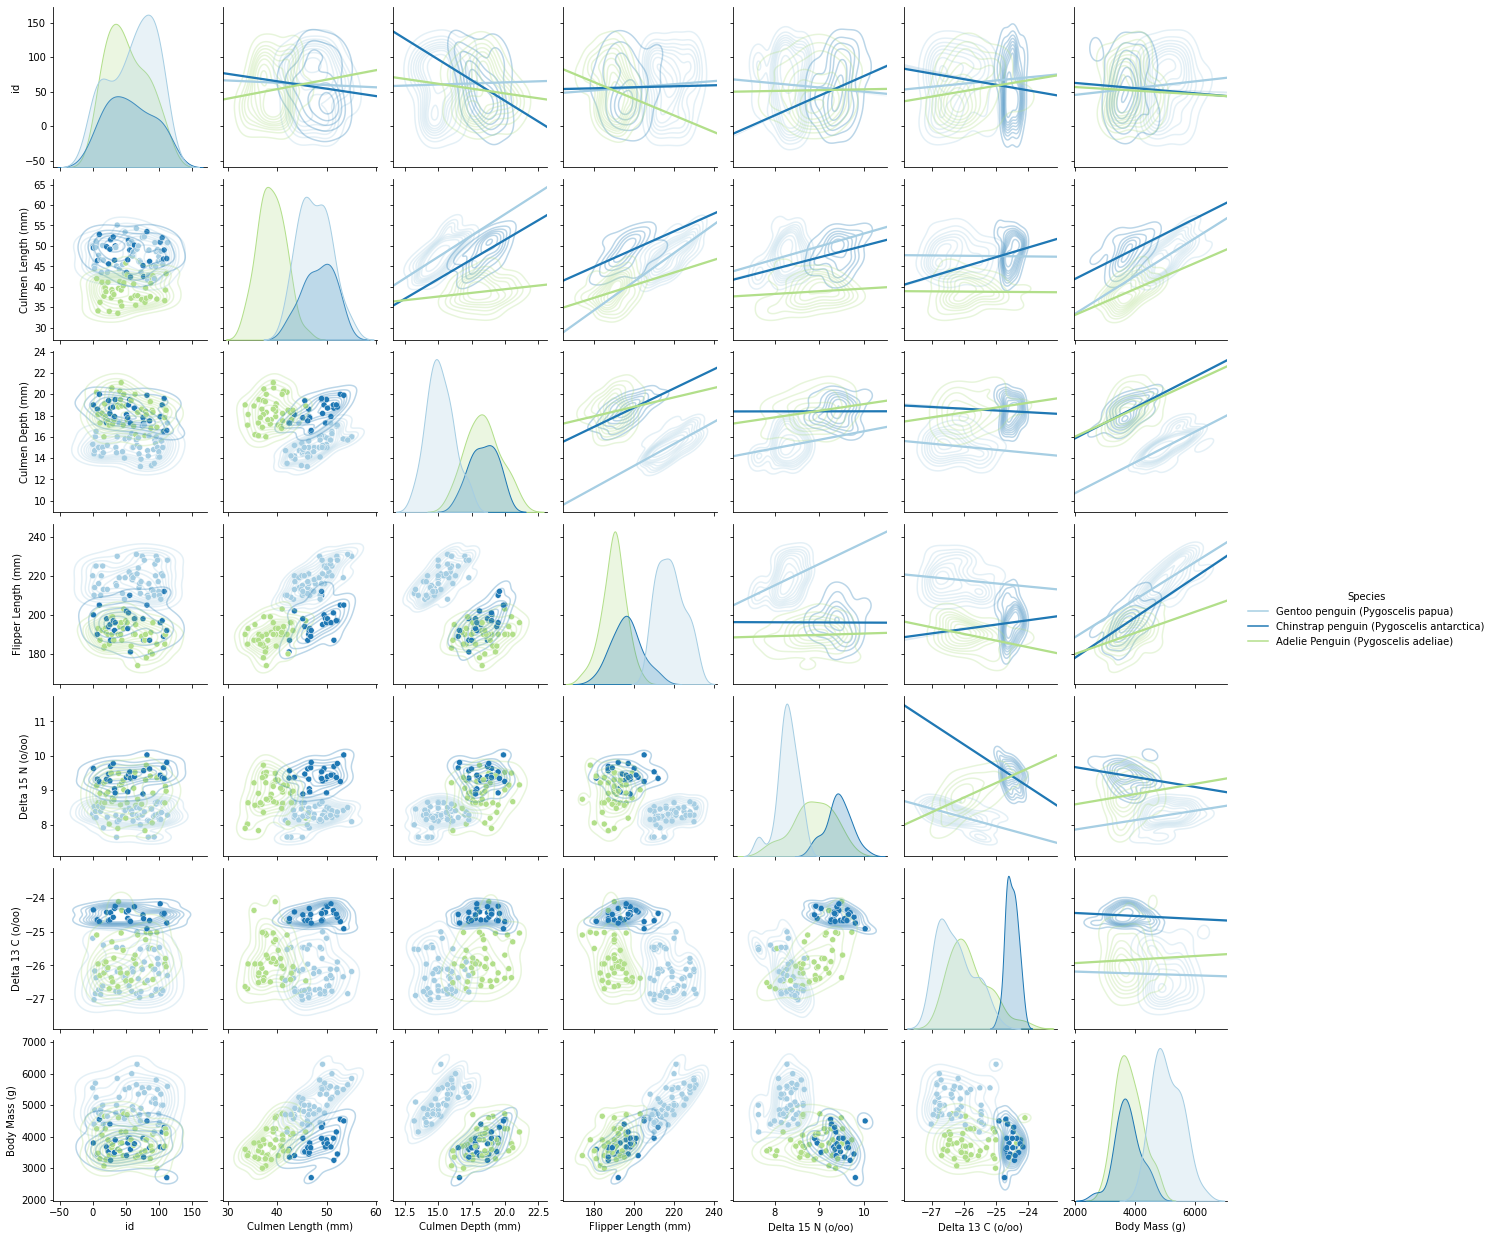

In [51]:
hue_Data = "Species"
g = sns.pairplot(train[[*nur_train,hue_Data]], hue=hue_Data, 
                 kind="kde", plot_kws={"alpha":0.3}, palette="Paired")
g.map_lower(sns.scatterplot)
g.map_upper(sns.regplot, scatter=False, truncate=False, ci=True)    
display(g)

# 모델 학습에 넣을 X Y 구하기

In [53]:
Sex_dummmies = pd.get_dummies(train['Sex'])
train = pd.concat((train, Sex_dummmies), axis=1)
train = train.drop(['Sex'], axis = 1)

train.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g),Adelie Penguin (Pygoscelis adeliae),Chinstrap penguin (Pygoscelis antarctica),Gentoo penguin (Pygoscelis papua),Biscoe,Dream,Torgersen,No,Yes,FEMALE,MALE
0,0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,8.30515,-25.19017,5550,0,0,1,1,0,0,0,1,0,1
1,1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,9.63074,-24.34684,3800,0,1,0,0,1,0,1,0,0,1
2,2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,8.51951,-27.01854,4400,0,0,1,1,0,0,0,1,1,0
3,3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,8.20106,-26.16524,4850,0,0,1,1,0,0,0,1,1,0
4,4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,8.38324,-26.84272,5700,0,0,1,1,0,0,1,0,0,1


In [102]:
X = train[features]
X.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Adelie Penguin (Pygoscelis adeliae),Chinstrap penguin (Pygoscelis antarctica),Gentoo penguin (Pygoscelis papua),Biscoe,Dream,Torgersen,FEMALE,MALE
0,50.0,15.3,220,8.30515,-25.19017,0,0,1,1,0,0,0,1
1,49.5,19.0,200,9.63074,-24.34684,0,1,0,0,1,0,0,1
2,45.1,14.4,210,8.51951,-27.01854,0,0,1,1,0,0,1,0
3,44.5,14.7,214,8.20106,-26.16524,0,0,1,1,0,0,1,0
4,49.6,16.0,225,8.38324,-26.84272,0,0,1,1,0,0,0,1


In [55]:
Y = train['Body Mass (g)']
Y = pd.DataFrame(Y)
Y.head()

,Body Mass (g)
0,5550
1,3800
2,4400
3,4850
4,5700


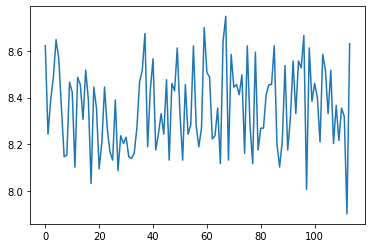

In [56]:
Y_log = np.log1p(Y['Body Mass (g)'])
Y_log.plot()

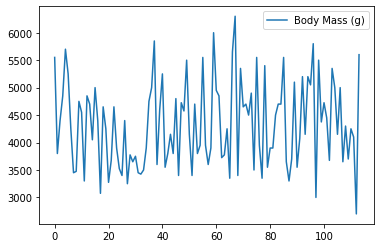

In [57]:
Y.plot()

# 어떤 모델이 괜찮은지 확인 (튜닝 전)

In [ ]:
# train 및 test 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(X,Y, random_state=23, test_size=0.1)

In [52]:
# LogisticRegression(), -> continuous에러 / LogisticRegression
models=[RandomForestRegressor(random_state=0), KNeighborsRegressor(), BaggingRegressor(random_state=0),
        GradientBoostingRegressor(random_state=23), 
        XGBRegressor(random_state=0), LGBMRegressor(random_state=0),
        AdaBoostRegressor(random_state=0), LinearRegression(), SVR(kernel='poly', degree = 2), SVR(kernel='rbf'), 
        Lasso(random_state=0), Ridge(random_state=0),
        ]
     
model_names=['RandomForestRegressor', 'KNeighborsRegressor', 'BaggingRegressor', 'GradientBoostingRegressor', 'XGBRegressor', 'LGBMRegressor',
             'AdaBoostRegressor', 'LinearRegression', 'SVR_poly', 'SVR_rbf', 'Lasso', 'Ridge'
          ]
rmse_list=[]
# d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(x_train,y_train)
    test_pred=clf.predict(x_test)

    k=0
    for i in test_pred:
      if i<0:
        test_pred[k] = 0
      k+=1

    rmse_list.append(rmse(test_pred,y_test))


for model in range(len(model_names)):
  print(model_names[model], 'RMSE : \t\t' , rmse_list[model] , '\n')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tru

[11:10:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RandomForestRegressor RMSE : 		 320.4369981629254 

KNeighborsRegressor RMSE : 		 378.010140957444 

BaggingRegressor RMSE : 		 354.00609104929254 

GradientBoostingRegressor RMSE : 		 321.9730126385717 

XGBRegressor RMSE : 		 274.72551787283703 

LGBMRegressor RMSE : 		 255.7593128163149 

AdaBoostRegressor RMSE : 		 321.6632821918189 

LinearRegression RMSE : 		 285.4426175059154 

SVR_poly RMSE : 		 644.0402651839145 

SVR_rbf RMSE : 		 645.3548521493111 

Lasso RMSE : 		 284.086185742634 

Ridge RMSE : 		 280.35347095123234 



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [63]:
#성지야 미안 일일히 입력하기 귀찮더라고... score 잘 쓸게.. ^^
score_List=[]

model = KNeighborsRegressor(n_neighbors=5).fit(x_train, y_train)
score_List.append(f'KNeighborsRegressor: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = LinearRegression().fit(x_train, y_train)
score_List.append(f'LinearRegression: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = Ridge(random_state=0).fit(x_train, y_train)
score_List.append(f'Ridge: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = Lasso(random_state=0).fit(x_train, y_train)
score_List.append(f'Lasso: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = RandomForestRegressor(random_state=0).fit(x_train, y_train)
score_List.append(f'RandomForestRegressor: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = GradientBoostingRegressor(random_state=0).fit(x_train, y_train)
score_List.append(f'GradientBoostingRegressor: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = XGBRegressor(random_state=0).fit(x_train, y_train)
score_List.append(f'XGBRegressor: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = LGBMRegressor(random_state=0).fit(x_train, y_train)
score_List.append(f'LGBMRegressor: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

model = AdaBoostRegressor(random_state=0).fit(x_train, y_train)
score_List.append(f'AdaBoostRegressor: train_score: {model.score(x_train, y_train)}, val_score: {model.score(x_test, y_test)}')

score_List

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[14:07:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['KNeighborsRegressor: train_score: 0.85129541575103, val_score: 0.5706317491783609',
 'LinearRegression: train_score: 0.8701190588616527, val_score: 0.7551722415157289',
 'Ridge: train_score: 0.8684873144997156, val_score: 0.7638244689005353',
 'Lasso: train_score: 0.8699870452351597, val_score: 0.7574935703711001',
 'RandomForestRegressor: train_score: 0.9729396253890769, val_score: 0.69146223068496',
 'GradientBoostingRegressor: train_score: 0.9901503985006437, val_score: 0.668418144625946',
 'XGBRegressor: train_score: 0.9793396732424096, val_score: 0.7732115005571124',
 'LGBMRegressor: train_score: 0.9117236540278361, val_score: 0.8034441659494518',
 'AdaBoostRegressor: train_score: 0.9348128971123967, val_score: 0.6890962186050483']

## 튜닝 후 모델?

In [66]:
# LogisticRegression(), -> continuous에러 / LogisticRegression
models=[RandomForestRegressor(), KNeighborsRegressor(), BaggingRegressor(), 
        GradientBoostingRegressor(random_state=23, n_estimators=33, max_depth=2, learning_rate=0.05), 
        XGBRegressor(n_estimators=70, n_jobs = -1, num_leaves = 3, max_depth=3, reg_lambda=0.01),
        LGBMRegressor(n_estimators = 37, n_jobs=-1, reg_lambda =5, random_state=23,  learning_rate=0.05),
        AdaBoostRegressor(random_state=0), LinearRegression(),
        SVR(kernel='poly', degree=2),
        SVR(kernel='rbf', gamma=1, C = 2), 
        Lasso(alpha =  0.01), 
        Ridge(alpha= 150),
        ]
     
model_names=['RandomForestRegressor', 'KNeighborsRegressor', 'BaggingRegressor', 'GradientBoostingRegressor', 'XGBRegressor', 'LGBMRegressor',
             'AdaBoostRegressor', 'LinearRegression', 'SVR_poly', 'SVR_rbf', 'Lasso', 'Ridge'
          ]
rmse_list=[]
# d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(x_train,y_train)
    test_pred=clf.predict(x_test)

    k=0
    for i in test_pred:
      if i<0:
        test_pred[k] = 0
      k+=1

    rmse_list.append(rmse(test_pred,y_test))


for model in range(len(model_names)):
  print(model_names[model], 'RMSE : \t\t' , rmse_list[model] , '\n')
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


[14:07:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RandomForestRegressor RMSE : 		 320.8746997141823 

KNeighborsRegressor RMSE : 		 378.010140957444 

BaggingRegressor RMSE : 		 340.05590839350714 

GradientBoostingRegressor RMSE : 		 261.73398448253295 

XGBRegressor RMSE : 		 324.0126076841397 

LGBMRegressor RMSE : 		 242.22125160546994 

AdaBoostRegressor RMSE : 		 321.6632821918189 

LinearRegression RMSE : 		 285.4426175059154 

SVR_poly RMSE : 		 644.0402651839145 

SVR_rbf RMSE : 		 646.22982808221 

Lasso RMSE : 		 285.42894248360983 

Ridge RMSE : 		 310.79421407071163 



/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ra

# 스케일링까지 한다면?

In [75]:
#id랑 Body Mess는 어짜피 삭제해야하니까 train[features] -> 여기서 int/float형만 가져옴.
train_scaled = train[features].select_dtypes(include = ['int', 'float'])
train_scaled.head()
# train_scaled.columns

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo)
0,50.0,15.3,220,8.30515,-25.19017
1,49.5,19.0,200,9.63074,-24.34684
2,45.1,14.4,210,8.51951,-27.01854
3,44.5,14.7,214,8.20106,-26.16524
4,49.6,16.0,225,8.38324,-26.84272


In [77]:
X.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Adelie Penguin (Pygoscelis adeliae),Chinstrap penguin (Pygoscelis antarctica),Gentoo penguin (Pygoscelis papua),Biscoe,Dream,Torgersen,FEMALE,MALE
0,50.0,15.3,220,8.30515,-25.19017,0,0,1,1,0,0,0,1
1,49.5,19.0,200,9.63074,-24.34684,0,1,0,0,1,0,0,1
2,45.1,14.4,210,8.51951,-27.01854,0,0,1,1,0,0,1,0
3,44.5,14.7,214,8.20106,-26.16524,0,0,1,1,0,0,1,0
4,49.6,16.0,225,8.38324,-26.84272,0,0,1,1,0,0,0,1


In [86]:
X_Scaled = X

In [104]:
scaler_CL = StandardScaler()
scaler_CD = StandardScaler()
scaler_FL = StandardScaler()
scaler_D15 = StandardScaler()
scaler_D13 = StandardScaler()

X_Scaled['Culmen Length (mm)'] = scaler_CL.fit_transform(pd.DataFrame(X['Culmen Length (mm)']))
X_Scaled['Culmen Depth (mm)'] = scaler_CD.fit_transform(pd.DataFrame(X['Culmen Depth (mm)']))
X_Scaled['Flipper Length (mm)'] = scaler_FL.fit_transform(pd.DataFrame(X['Flipper Length (mm)']))
X_Scaled['Delta 15 N (o/oo)'] = scaler_D15.fit_transform(pd.DataFrame(X['Delta 15 N (o/oo)']))
X_Scaled['Delta 13 C (o/oo)'] = scaler_D13.fit_transform(pd.DataFrame(X['Delta 13 C (o/oo)']))

X_Scaled

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Adelie Penguin (Pygoscelis adeliae),Chinstrap penguin (Pygoscelis antarctica),Gentoo penguin (Pygoscelis papua),Biscoe,Dream,Torgersen,FEMALE,MALE
0,1.016685,-0.887255,1.161653,-0.770241,0.637574,0,0,1,1,0,0,0,1
1,0.922318,1.027037,-0.209242,1.605781,1.635141,0,1,0,0,1,0,0,1
2,0.091884,-1.352893,0.476205,-0.386016,-1.525190,0,0,1,1,0,0,1,0
3,-0.021357,-1.197680,0.750384,-0.956814,-0.515828,0,0,1,1,0,0,1,0
4,0.941191,-0.525091,1.504376,-0.630270,-1.317214,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,-1.512363,0.406186,-1.237413,-0.183329,-0.267622,1,0,0,0,0,1,1,0
110,-1.021652,0.820087,-0.894689,0.672501,-0.078454,1,0,0,0,1,0,0,1
111,-0.266712,0.768349,-0.757600,0.421901,-0.363886,1,0,0,0,1,0,0,1
112,0.431607,-0.214666,-0.757600,1.919724,1.173210,0,1,0,0,1,0,1,0


In [82]:
x_train_scaler, x_test_scaler, y_train_scaler, y_test_scaler = train_test_split(X_Scaled ,Y, random_state=23, test_size=0.1)

In [108]:
# LogisticRegression(), -> continuous에러 / LogisticRegression
models=[RandomForestRegressor(random_state=0), KNeighborsRegressor(), BaggingRegressor(random_state=0),
        GradientBoostingRegressor(random_state=23), 
        XGBRegressor(random_state=0), LGBMRegressor(random_state=0),
        AdaBoostRegressor(random_state=0), LinearRegression(), SVR(kernel='poly', degree = 2), SVR(kernel='rbf'), 
        Lasso(random_state=0), Ridge(random_state=0),
        ]
     
model_names=['RandomForestRegressor', 'KNeighborsRegressor', 'BaggingRegressor', 'GradientBoostingRegressor', 'XGBRegressor', 'LGBMRegressor',
             'AdaBoostRegressor', 'LinearRegression', 'SVR_poly', 'SVR_rbf', 'Lasso', 'Ridge'
          ]
rmse_list=[]
# d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(x_train_scaler,y_train_scaler)
    test_pred=clf.predict(x_test_scaler)

    k=0
    for i in test_pred:
      if i<0:
        test_pred[k] = 0
      k+=1

    rmse_list.append(rmse(test_pred,y_test_scaler))


for model in range(len(model_names)):
  print(model_names[model], 'RMSE : \t\t' , rmse_list[model] , '\n')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[14:27:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RandomForestRegressor RMSE : 		 376.2277125181858 

KNeighborsRegressor RMSE : 		 295.5045120918912 

BaggingRegressor RMSE : 		 388.3914477259594 

GradientBoostingRegressor RMSE : 		 376.8743362625536 

XGBRegressor RMSE : 		 368.33228494783907 

LGBMRegressor RMSE : 		 293.8784228942199 

AdaBoostRegressor RMSE : 		 326.5327982135918 

LinearRegression RMSE : 		 338.9696616077395 

SVR_poly RMSE : 		 647.0523494836893 

SVR_rbf RMSE : 		 627.0890679360105 

Lasso RMSE : 		 338.8272779539544 

Ridge RMSE : 		 339.42516415429805 



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

<font color=red > 오히려 성능이 더 안좋아진 것을 볼 수 있음. </font>

### test 데이터 NA값 보간법 (위에서 진행) 및 One-Hot 진행 


In [67]:
Sex_dummmies = pd.get_dummies(test['Sex'])
test = pd.concat((test, Sex_dummmies), axis=1)
test = test.drop(['Sex'], axis = 1)

test.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Adelie Penguin (Pygoscelis adeliae),Chinstrap penguin (Pygoscelis antarctica),Gentoo penguin (Pygoscelis papua),Biscoe,Dream,Torgersen,No,Yes,FEMALE,MALE
0,0,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,52.0,20.7,210.0,9.43146,-24.68440,0,1,0,0,1,0,0,1,0,1
1,1,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,55.9,17.0,228.0,8.31180,-26.35425,0,0,1,1,0,0,0,1,0,1
2,2,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,38.9,18.8,190.0,8.36936,-26.11199,1,0,0,0,1,0,0,1,1,0
3,3,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,45.2,16.6,191.0,9.62357,-24.78984,0,1,0,0,1,0,0,1,1,0
4,4,Adelie Penguin (Pygoscelis adeliae),Biscoe,No,37.9,18.6,172.0,8.38404,-25.19837,1,0,0,1,0,0,1,0,1,0


In [68]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 19 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         228 non-null    int64  
 1   Species                                    228 non-null    object 
 2   Island                                     228 non-null    object 
 3   Clutch Completion                          228 non-null    object 
 4   Culmen Length (mm)                         228 non-null    float64
 5   Culmen Depth (mm)                          228 non-null    float64
 6   Flipper Length (mm)                        228 non-null    float64
 7   Delta 15 N (o/oo)                          228 non-null    float64
 8   Delta 13 C (o/oo)                          228 non-null    float64
 9   Adelie Penguin (Pygoscelis adeliae)        228 non-null    uint8  
 10  Chinstrap penguin (Pygosce

In [69]:
test = test[features]
test.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Adelie Penguin (Pygoscelis adeliae),Chinstrap penguin (Pygoscelis antarctica),Gentoo penguin (Pygoscelis papua),Biscoe,Dream,Torgersen,FEMALE,MALE
0,52.0,20.7,210.0,9.43146,-24.68440,0,1,0,0,1,0,0,1
1,55.9,17.0,228.0,8.31180,-26.35425,0,0,1,1,0,0,0,1
2,38.9,18.8,190.0,8.36936,-26.11199,1,0,0,0,1,0,1,0
3,45.2,16.6,191.0,9.62357,-24.78984,0,1,0,0,1,0,1,0
4,37.9,18.6,172.0,8.38404,-25.19837,1,0,0,1,0,0,1,0


##과연 결과는?

In [70]:
sample_submission = pd.read_csv('/content/drive/MyDrive/penguin/sample_submission.csv')
sample_submission

,id,Body Mass (g)
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
223,223,0
224,224,0
225,225,0
226,226,0


## 업로드

## 1. LGBM 튜닝

In [73]:
# LGBM 파라메타 참고
# hyperparameters = {'boosting_type': 'gbdt', 
#                    'colsample_bytree': 0.7250136792694301, 
#                    'is_unbalance': False, 
#                    'learning_rate': 0.013227664889528229,
#                    'min_child_samples': 20, 
#                    'num_leaves': 56, 
#                    'reg_alpha': 0.7543896477745794, 
#                    'reg_lambda': 0.07152751159655985, 
#                    'subsample_for_bin': 240000, 
#                    'subsample': 0.5233384321711397, 
#                    'n_estimators': 2000}

In [74]:
parameters = {
    "n_estimators" : [30,40,50,60,70,80, 85, 90, 95, 100],
    # 'num_leaves': [2,3,4,5,6,7,8,9,10],
    'reg_lambda' : [2,3,4,5,6,7],
    'n_jobs' : [-1],
    'learning_rate': [0.1, 0.05],
    }
    
#verbose = 2 -> Grid Search 반복시 하이퍼 파라메타별 메시지를 화면에 출력 
#cv=5 5번의 교차검증.
grid = GridSearchCV(LGBMRegressor(random_state=0), parameters, verbose=2, cv=5)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END learning_rate=0.1, n_estimators=30, n_jobs=-1, reg_lambda=2; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=30, n_jobs=-1, reg_lambda=2; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=30, n_jobs=-1, reg_lambda=2; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=30, n_jobs=-1, reg_lambda=2; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=30, n_jobs=-1, reg_lambda=2; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=30, n_jobs=-1, reg_lambda=3; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=30, n_jobs=-1, reg_lambda=3; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=30, n_jobs=-1, reg_lambda=3; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=30, n_jobs=-1, reg_lambda=3; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=30, n_jobs=-1, reg_lambda=3; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=30, n_

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=0),
             param_grid={'learning_rate': [0.1, 0.05],
                         'n_estimators': [30, 40, 50, 60, 70, 80, 85, 90, 95,
                                          100],
                         'n_jobs': [-1], 'reg_lambda': [2, 3, 4, 5, 6, 7]},
             verbose=2)

In [75]:
grid.best_params_

{'learning_rate': 0.05, 'n_estimators': 100, 'n_jobs': -1, 'reg_lambda': 5}

In [76]:
model_lstm = LGBMRegressor(n_estimators = 100, n_jobs=-1, reg_lambda = 5, random_state=0, learning_rate=0.05).fit(x_train, y_train)
model_lstm.score(x_train, y_train), model_lstm.score(x_test, y_test)


(0.8853934836211895, 0.819936292279172)

In [77]:
# LGBMRegressor(n_estimators = 37, n_jobs=-1, reg_lambda =5, random_state=23,  learning_rate=0.05),       # 242.2215
#model_lstm = LGBMRegressor(n_estimators = 40, n_jobs=-1, reg_lambda = 5, random_state=0, learning_rate=0.05).fit(x_train, y_train) #238

In [78]:
x_pred = model_lstm.predict(x_test)
rmse(x_pred,y_test)

244.7944579025458

In [79]:
x_train, x_test, y_train_log, y_test_log = train_test_split(X ,Y_log, random_state=0, test_size=0.1)

In [80]:
model_lstm = LGBMRegressor(n_estimators = 100, n_jobs=-1, reg_lambda = 5, random_state=0, learning_rate=0.05).fit(x_train, y_train_log)
model_lstm.score(x_train, y_train_log), model_lstm.score(x_test, y_test_log)


(0.8683155706365748, 0.9299258165307103)

In [81]:
x_pred = model_lstm.predict(x_test)
rmse(np.expm1(x_pred), np.expm1(y_test_log))

204.62447038589198

In [86]:
#케글에 업로드하며 수치 확인하기 위해 csv 확인으로 변환.
sample_submission.to_csv('sample_submission_lstm_log_sc.csv', index=False)

## 순서가 꼬였지만. 여기는 XGB 튜닝

In [91]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor(random_state=0).fit(x_train, y_train)
model_xgb.score(x_train, y_train) , model_xgb.score(x_test, y_test)

[11:12:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(0.9775758781073927, 0.7930199046113147)

In [92]:
x_pred = model_xgb.predict(x_test)
rmse((x_pred), (y_test))

325.2424322303704

In [93]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "n_estimators" : [50, 55,60,65,70,75,80,90],
    'max_depth' : [2],
    # 'min_child_samples': [1,2,3,4,5] ,
    # 'num_leaves': [2,3,4],
    'n_jobs' : [-1],
    'reg_lambda' : [0.01, 0.1, 1, 2],
    'learing_rate' : [0.1, 0.2, 0.01, 0.05]
    }
    
#verbose = 2 -> Grid Search 반복시 하이퍼 파라메타별 메시지를 화면에 출력 
#cv=5 5번의 교차검증.
grid = GridSearchCV(model_xgb, parameters, verbose=2, cv=5)
grid.fit(X, Y)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[11:12:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END learing_rate=0.1, max_depth=2, n_estimators=50, n_jobs=-1, reg_lambda=0.01; total time=   0.0s
[11:12:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END learing_rate=0.1, max_depth=2, n_estimators=50, n_jobs=-1, reg_lambda=0.01; total time=   0.0s
[11:12:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END learing_rate=0.1, max_depth=2, n_estimators=50, n_jobs=-1, reg_lambda=0.01; total time=   0.0s
[11:12:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END learing_rate=0.1, max_depth=2, n_estimators=50, n_jobs=-1, reg_lambda=0.01; total time=   0.0s
[11:12:33] WA

GridSearchCV(cv=5, estimator=XGBRegressor(),
             param_grid={'learing_rate': [0.1, 0.2, 0.01, 0.05],
                         'max_depth': [2],
                         'n_estimators': [50, 55, 60, 65, 70, 75, 80, 90],
                         'n_jobs': [-1], 'reg_lambda': [0.01, 0.1, 1, 2]},
             verbose=2)

In [94]:
grid.best_params_

{'learing_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 50,
 'n_jobs': -1,
 'reg_lambda': 0.1}

In [95]:
grid.best_score_

0.796211305769678

In [97]:
model_xgb = XGBRegressor(
    n_estimators=55, n_jobs = -1, max_depth=2, reg_lambda=0.1,learning_rate=0.1, random_state=0).fit(x_train, y_train)
model_xgb.score(x_train, y_train) , model_xgb.score(x_test, y_test)

[11:12:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(0.936829703499853, 0.8199271674245083)

In [98]:
xgb_pred = model_xgb.predict(x_test)
rmse(xgb_pred, y_test)

303.36607095994725

In [100]:
model_xgb = XGBRegressor(
    n_estimators=55, n_jobs = -1, max_depth=2, reg_lambda=0.1,learning_rate=0.1).fit(x_train, y_train_log)
model_xgb.score(x_train, y_train_log) , model_xgb.score(x_test, y_test_log)

[11:12:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(0.9015269219435601, 0.8621489731789717)

In [101]:
xgb_pred = model_xgb.predict(x_test)
rmse(np.expm1(xgb_pred), np.expm1(y_test))

288.8335003203038

## GBM도 가보자구~~


In [102]:
from sklearn.model_selection import GridSearchCV
model_gbm = GradientBoostingRegressor(random_state=23)
parameters = {
    "n_estimators" : [30,40,50, 55, 60, 65, 70, 75, 80,90,100,120],
    'max_depth' : [2,3],
    'learning_rate' : [0.05, 0.01, 0.5, 1],
    }

#SVR 모델 Grid Search , 파라메타들은 위에서 설정한 파라메타
#verbose = 2 -> Grid Search 반복시 하이퍼 파라메타별 메시지를 화면에 출력 
#cv=5 5번의 교차검증.
grid = GridSearchCV(model_gbm, parameters, verbose=2, cv=5)
grid.fit(X, Y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=30; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=30; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=30; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=30; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=30; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=40; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=40; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=40; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=40; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=40; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=55; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=55; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=55; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=55; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=55; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=60; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=65; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=65; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=65; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=65; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=65; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=75; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=75; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=75; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=75; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=75; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=80; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=80; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=80; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=80; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=80; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=90; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=90; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=90; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=90; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=2, n_estimators=90; total time=   0.0s
[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=120; total time=   0.0s
[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=120; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=120; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=120; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=120; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=30; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=40; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=40; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=40; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=40; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=40; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=55; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=55; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=55; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=55; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=55; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=65; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=65; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=65; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=65; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=65; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=70; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=70; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=70; total time=   0.1s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=70; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=70; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=75; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=75; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=75; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=75; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=75; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=80; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=80; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=80; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=80; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=80; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=90; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=90; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=90; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=90; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=3, n_estimators=90; total time=   0.0s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=120; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=120; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=120; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=120; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=120; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=30; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=30; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=30; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=30; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=30; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=40; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=40; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=40; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=40; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=40; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=55; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=55; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=55; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=55; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=55; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=60; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=65; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=65; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=65; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=65; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=65; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=70; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=75; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=75; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=75; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=75; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=75; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=80; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=80; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=80; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=80; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=80; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=90; total time=   0.1s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=90; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=90; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=90; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=90; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=120; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=120; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=120; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=120; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=120; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=40; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=40; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=40; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=40; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=40; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=55; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=55; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=55; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=55; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=55; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=60; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=65; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=65; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=65; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=65; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=65; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=70; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=70; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=70; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=70; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=70; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=75; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=75; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=75; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=75; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=75; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=80; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=80; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=80; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=80; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=80; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=90; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=90; total time=   0.1s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=90; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=90; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=90; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=120; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=120; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=120; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=120; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=120; total time=   0.1s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=30; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=30; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=30; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=30; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=30; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=40; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=40; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=40; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=40; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=40; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=50; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=55; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=55; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=55; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=55; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=55; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=60; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=60; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=60; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=60; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=60; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=65; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=65; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=65; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=65; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=65; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=70; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=75; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=75; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=75; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=75; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=75; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=80; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=80; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=80; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=80; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=80; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=90; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=90; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=90; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=90; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=2, n_estimators=90; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=100; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=120; total time=   0.1s
[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=120; total time=   0.1s
[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=120; total time=   0.1s
[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=120; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=120; total time=   0.1s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=40; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=40; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=40; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=40; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=40; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=50; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=55; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=55; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=55; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=55; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=55; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=60; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=60; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=60; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=60; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=60; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=65; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=65; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=65; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=65; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=65; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=70; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=70; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=70; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=70; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=70; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=75; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=75; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=75; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=75; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=75; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=80; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=80; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=80; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=80; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=80; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=90; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=90; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=90; total time=   0.0s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=90; total time=   0.1s
[CV] END ....learning_rate=0.5, max_depth=3, n_estimators=90; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.5, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.5, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.5, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.5, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.5, max_depth=3, n_estimators=100; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.5, max_depth=3, n_estimators=120; total time=   0.1s
[CV] END ...learning_rate=0.5, max_depth=3, n_estimators=120; total time=   0.1s
[CV] END ...learning_rate=0.5, max_depth=3, n_estimators=120; total time=   0.1s
[CV] END ...learning_rate=0.5, max_depth=3, n_estimators=120; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ...learning_rate=0.5, max_depth=3, n_estimators=120; total time=   0.1s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=30; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=30; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=30; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=30; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=30; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=40; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=40; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=40; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ......learning_rate=1, max_depth=2, n_estimators=40; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=40; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=55; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ......learning_rate=1, max_depth=2, n_estimators=55; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=55; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=55; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=55; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=60; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=60; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=60; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ......learning_rate=1, max_depth=2, n_estimators=60; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=60; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=65; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=65; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=65; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=65; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=65; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ......learning_rate=1, max_depth=2, n_estimators=70; total time=   0.1s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=70; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=75; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ......learning_rate=1, max_depth=2, n_estimators=75; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=75; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=75; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=75; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=80; total time=   0.1s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=80; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ......learning_rate=1, max_depth=2, n_estimators=80; total time=   0.1s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=80; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=80; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=90; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=90; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=90; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ......learning_rate=1, max_depth=2, n_estimators=90; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=2, n_estimators=90; total time=   0.0s
[CV] END .....learning_rate=1, max_depth=2, n_estimators=100; total time=   0.0s
[CV] END .....learning_rate=1, max_depth=2, n_estimators=100; total time=   0.0s
[CV] END .....learning_rate=1, max_depth=2, n_estimators=100; total time=   0.0s
[CV] END .....learning_rate=1, max_depth=2, n_estimators=100; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END .....learning_rate=1, max_depth=2, n_estimators=100; total time=   0.0s
[CV] END .....learning_rate=1, max_depth=2, n_estimators=120; total time=   0.0s
[CV] END .....learning_rate=1, max_depth=2, n_estimators=120; total time=   0.0s
[CV] END .....learning_rate=1, max_depth=2, n_estimators=120; total time=   0.0s
[CV] END .....learning_rate=1, max_depth=2, n_estimators=120; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END .....learning_rate=1, max_depth=2, n_estimators=120; total time=   0.1s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=30; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=40; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=40; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=40; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ......learning_rate=1, max_depth=3, n_estimators=40; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=40; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=50; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ......learning_rate=1, max_depth=3, n_estimators=55; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=55; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=55; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=55; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=55; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=60; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=60; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ......learning_rate=1, max_depth=3, n_estimators=60; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=60; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=60; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=65; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=65; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=65; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ......learning_rate=1, max_depth=3, n_estimators=65; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=65; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=70; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=70; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=70; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=70; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ......learning_rate=1, max_depth=3, n_estimators=70; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=75; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=75; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=75; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=75; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=75; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ......learning_rate=1, max_depth=3, n_estimators=80; total time=   0.1s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=80; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=80; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=80; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=80; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=90; total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END ......learning_rate=1, max_depth=3, n_estimators=90; total time=   0.1s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=90; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=90; total time=   0.0s
[CV] END ......learning_rate=1, max_depth=3, n_estimators=90; total time=   0.0s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END .....learning_rate=1, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=120; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV] END .....learning_rate=1, max_depth=3, n_estimators=120; total time=   0.1s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=120; total time=   0.1s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=120; total time=   0.1s
[CV] END .....learning_rate=1, max_depth=3, n_estimators=120; total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=23),
             param_grid={'learning_rate': [0.05, 0.01, 0.5, 1],
                         'max_depth': [2, 3],
                         'n_estimators': [30, 40, 50, 55, 60, 65, 70, 75, 80,
                                          90, 100, 120]},
             verbose=2)

In [103]:
grid.best_params_

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 65}

In [105]:
from sklearn.ensemble import GradientBoostingRegressor
model_gbm = GradientBoostingRegressor(random_state=0, n_estimators=65, max_depth=2, learning_rate=0.05).fit(x_train, y_train)
model_gbm.score(x_train ,y_train), model_gbm.score(x_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.9100818163045715, 0.8627708217348069)

In [106]:
rmse(model_gbm.predict(x_test), y_test)

264.82936558841897

In [107]:
#train_test_split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X ,Y_log, random_state=0, test_size=0.1)

model_gbm = GradientBoostingRegressor(random_state=0, n_estimators=65, max_depth=2, learning_rate=0.05).fit(x_train, y_train_log)
rmse(np.expm1(model_gbm.predict(x_test)), np.expm1(y_test_log))

269.06997905545956

## SVM 해보자 -> 하자고 한 나영훈 죽어

In [108]:
from sklearn.svm import SVR
model_svr = SVR()

In [109]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'kernel' : ['rbf'],
    'gamma' : [2,3,4,5],
    'C' : [0.01, 0.1, 1, 10], 
    'epsilon' : [0.01, 0.1, 0, 1, 10],
    'coef0' : [0.001, 0.01, 0.1, 0, 1, 10]
    }
#verbose = 2 -> Grid Search 반복시 하이퍼 파라메타별 메시지를 화면에 출력 
#cv=5 5번의 교차검증.
grid = GridSearchCV(SVR(), parameters, verbose=2, cv=5)
grid.fit(X, Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[CV] END C=0.01, coef0=0.001, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END C=0.01, coef0=0.001, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END C=0.01, coef0=0.001, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END C=0.01, coef0=0.001, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END C=0.01, coef0=0.001, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.001, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END C=0.01, coef0=0.01, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END C=0.01, coef0=0.01, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.01

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .C=0.01, coef0=0.01, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .C=0.01, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.01, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END C=0.01, coef0=0.01, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.01, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.1, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.1, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.1, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END C=0.01, coef0=0.1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin


[CV] END C=0.01, coef0=0.1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=0.1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ..C=0.01, coef0=0.1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ..C=0.01, coef0=0.1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0.1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.1, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.1, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.1, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.1, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.1, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.1,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .C=0.01, coef0=0.1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0.1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=0, e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ..C=0.01, coef0=0, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=0, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ....C=0.01, coef0=0, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ....C=0.01, coef0=0, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ...C=0.01, coef0=0, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=0, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=0, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=0, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=0, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=0, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=0, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=0, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=0, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=0, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=0, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=0, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=0,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .C=0.01, coef0=1, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=1, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=1, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=1, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=1, e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ..C=0.01, coef0=1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=1, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ....C=0.01, coef0=1, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ....C=0.01, coef0=1, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, coef0=1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ...C=0.01, coef0=1, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=1,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END C=0.01, coef0=10, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=10, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=10, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=10, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=10, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=10, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=10, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=10, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=10, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=10, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=10, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=10, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.01, coef0=10, e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .C=0.01, coef0=10, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=10, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=10, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=10, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=10, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=10, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=10, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.01, coef0=10, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ...C=0.01, coef0=10, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ...C=0.01, coef0=10, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.01, coef0=10

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ..C=0.01, coef0=10, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=10, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=10, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=10, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=10, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=10, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=10, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=10, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=10, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=10, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=10, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=10, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, coef0=10,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END C=0.1, coef0=0.001, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END C=0.1, coef0=0.001, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .C=0.1, coef0=0.001, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .C=0.1, coef0=0.001, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.001

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END C=0.1, coef0=0.001, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.001,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END C=0.1, coef0=0.01, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END C=0.1, coef0=0.01, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.01, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ..C=0.1, coef0=0.01, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ..C=0.1, coef0=0.01, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.01, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.01, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.01,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .C=0.1, coef0=0.01, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.01, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.01, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.01, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.01, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.01, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.01, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.01, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.01, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.01, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.01, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.01, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.1, e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END C=0.1, coef0=0.1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=0.1, coef0=0.1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.1, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .C=0.1, coef0=0.1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=0.1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ...C=0.1, coef0=0.1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ...C=0.1, coef0=0.1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0.1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.1, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.1, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.1, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.1, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.1,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ..C=0.1, coef0=0.1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0.1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0, e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ..C=0.1, coef0=0, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=0, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ...C=0.1, coef0=0, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=0, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .....C=0.1, coef0=0, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .....C=0.1, coef0=0, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=0, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=0, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=0, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=0, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=0, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=0, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=0, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=0, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=0, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=0,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ....C=0.1, coef0=0, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=0, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=0, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=0, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=1, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=1, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=1, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=1, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=1, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=1, e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ..C=0.1, coef0=1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=1, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .....C=0.1, coef0=1, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .....C=0.1, coef0=1, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=0.1, coef0=1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ....C=0.1, coef0=1, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=1, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=1, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=1, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=1,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .C=0.1, coef0=10, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=10, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=10, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=10, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=10, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=10, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=10, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=10, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=10, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=10, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=10, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=10, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=0.1, coef0=10, e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ..C=0.1, coef0=10, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=10, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=10, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=10, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=10, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=10, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=10, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=0.1, coef0=10, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ....C=0.1, coef0=10, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ....C=0.1, coef0=10, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=0.1, coef0=10

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ...C=0.1, coef0=10, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=10, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=10, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=10, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=10, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=10, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=10, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=10, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=10, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=10, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=10, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=10, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=0.1, coef0=10,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END C=1, coef0=0.001, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=1, coef0=0.001, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=1, coef0=0.001, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=1, coef0=0.001, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=1, coef0=0.001, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=1, coef0=0.001, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=1, coef0=0.001, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=1, coef0=0.001, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=1, coef0=0.001, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=1, coef0=0.001, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=1, coef0=0.001, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=1, coef0=0.001, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=1, coef0=0.001, e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .C=1, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.001, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.001, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.001, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.001, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.001, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.001, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.001, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.001, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ...C=1, coef0=0.001, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ...C=1, coef0=0.001, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.001, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.001,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ..C=1, coef0=0.001, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.001, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.001, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.001, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.001, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.001, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.001, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.01, e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .C=1, coef0=0.01, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.01, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.01, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.01, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.01, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.01, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.01, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=1, coef0=0.01, e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ..C=1, coef0=0.01, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.01, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.01, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.01, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.01, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.01, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.01, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.01, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ....C=1, coef0=0.01, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ....C=1, coef0=0.01, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.01, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.01, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.01,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ...C=1, coef0=0.01, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.01, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.01, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.01, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.01, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.01, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.01, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.01, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.01, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.01, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.01, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.1, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.1, e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ..C=1, coef0=0.1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=1, coef0=0.1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.1, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ...C=1, coef0=0.1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=0.1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .....C=1, coef0=0.1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .....C=1, coef0=0.1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0.1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.1, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.1, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.1,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ....C=1, coef0=0.1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0.1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0, e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ....C=1, coef0=0, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=0, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .....C=1, coef0=0, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=0, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .......C=1, coef0=0, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .......C=1, coef0=0, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=0, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=0,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ......C=1, coef0=0, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=0, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=0, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=0, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=0, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=0, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=0, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=0, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=0, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=0, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=0, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=0, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=0,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ....C=1, coef0=1, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=1, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=1, e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .....C=1, coef0=1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=1, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .......C=1, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .......C=1, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .......C=1, coef0=1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ......C=1, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=1,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ...C=1, coef0=10, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=10, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=10, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=10, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=10, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=10, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=10, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=10, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=10, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=10, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=10, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=10, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=1, coef0=10, e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ....C=1, coef0=10, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=10, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=10, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=10, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=10, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=10, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=10, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=1, coef0=10, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ......C=1, coef0=10, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ......C=1, coef0=10, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=1, coef0=10

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .....C=1, coef0=10, epsilon=10, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=10, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=10, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=10, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=10, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=10, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=10, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=10, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=10, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=10, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=10, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=10, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=1, coef0=10,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END C=10, coef0=0.001, epsilon=0.01, gamma=2, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=10, c

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END C=10, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.001, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ..C=10, coef0=0.001, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ..C=10, coef0=0.001, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.001, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.001,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .C=10, coef0=0.001, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.001, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.001, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.001, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.001, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.001, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.001, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.001, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.001,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END C=10, coef0=0.01, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END C=10, coef0=0.01, e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .C=10, coef0=0.01, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.01, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.01, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.01, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.01, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.01, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.01, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.01, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.01, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ...C=10, coef0=0.01, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ...C=10, coef0=0.01, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.01

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ..C=10, coef0=0.01, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.01, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.01, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.01, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.01, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.01, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.01, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.01, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.01, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.01, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.01, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.01, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.01,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .C=10, coef0=0.1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .C=10, coef0=0.1, e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ..C=10, coef0=0.1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=0.1, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ....C=10, coef0=0.1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ....C=10, coef0=0.1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0.1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ...C=10, coef0=0.1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0.1,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ...C=10, coef0=0, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=0, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ....C=10, coef0=0, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=0, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ......C=10, coef0=0, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ......C=10, coef0=0, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .....C=10, coef0=0, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=0, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=0, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=0, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=0, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=0, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=0, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=0, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=0, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=0, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=0, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=0, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=0,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ...C=10, coef0=1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=1, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=1, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=1, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=1, e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ....C=10, coef0=1, epsilon=0.1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=1, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=1, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=1, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=1, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ......C=10, coef0=1, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ......C=10, coef0=1, epsilon=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ......C=10, coef0=1

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .....C=10, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=1, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=1, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=1, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=1,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ..C=10, coef0=10, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=10, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=10, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=10, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=10, epsilon=0.01, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=10, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=10, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=10, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=10, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=10, epsilon=0.01, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=10, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=10, epsilon=0.01, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ..C=10, coef0=10, e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ...C=10, coef0=10, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=10, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=10, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=10, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=10, epsilon=0.1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=10, epsilon=0.1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=10, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=10, epsilon=0.1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ...C=10, coef0=10, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .....C=10, coef0=10, epsilon=0, gamma=2, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=0, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=0, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=0, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END .....C=10, coef0=10, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=1, gamma=3, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=1, gamma=4, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10, epsilon=1, gamma=5, kernel=rbf; total time=   0.0s
[CV] END .....C=10, coef0=10

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV] END ....C=10, coef0=10, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=10, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=10, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=10, epsilon=10, gamma=3, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=10, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=10, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=10, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=10, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=10, epsilon=10, gamma=4, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=10, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=10, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=10, epsilon=10, gamma=5, kernel=rbf; total time=   0.0s
[CV] END ....C=10, coef0=10,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'coef0': [0.001, 0.01, 0.1, 0, 1, 10],
                         'epsilon': [0.01, 0.1, 0, 1, 10],
                         'gamma': [2, 3, 4, 5], 'kernel': ['rbf']},
             verbose=2)

In [110]:
grid.best_params_

{'C': 10, 'coef0': 0.001, 'epsilon': 10, 'gamma': 2, 'kernel': 'rbf'}

In [114]:
from sklearn.svm import SVR
model_svr = SVR(kernel='poly', degree=2, C=0.01, coef0=10, epsilon=0.01).fit(x_train, y_train)
model_svr.score(x_train, y_train) , model_xgb.score(x_test, y_test)
rmse(model_svr.predict(x_test) , y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


612.6176307624083

In [117]:
from sklearn.svm import SVR
model_svr = SVR(kernel='rbf', gamma=1,).fit(x_train, y_train)
model_svr.score(x_train, y_train) , model_xgb.score(x_test, y_test)
rmse(model_svr.predict(x_test) , y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


612.5986276502747

## LASSO가 진짜 해답인가..

In [119]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

alphas = np.array([
                  #  10000,1000,100,10,1,0.1,0.01, 0.001, 0.0001, 0.00001, 0.000001, 0
                   0.1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15, 16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
])
lasso_reg = Lasso(random_state = 0)
grid_lasso = GridSearchCV(estimator=lasso_reg, param_grid=dict(alpha=alphas), verbose = 5)
grid_lasso.fit(x_train, y_train)

Fitting 5 folds for each of 31 candidates, totalling 155 fits
[CV 1/5] END .........................alpha=0.1;, score=0.737 total time=   0.0s
[CV 2/5] END .........................alpha=0.1;, score=0.800 total time=   0.0s
[CV 3/5] END .........................alpha=0.1;, score=0.815 total time=   0.0s
[CV 4/5] END .........................alpha=0.1;, score=0.908 total time=   0.0s
[CV 5/5] END .........................alpha=0.1;, score=0.715 total time=   0.0s
[CV 1/5] END .........................alpha=1.0;, score=0.739 total time=   0.0s
[CV 2/5] END .........................alpha=1.0;, score=0.801 total time=   0.0s
[CV 3/5] END .........................alpha=1.0;, score=0.816 total time=   0.0s
[CV 4/5] END .........................alpha=1.0;, score=0.910 total time=   0.0s
[CV 5/5] END .........................alpha=1.0;, score=0.719 total time=   0.0s
[CV 1/5] END .........................alpha=2.0;, score=0.740 total time=   0.0s
[CV 2/5] END .........................alpha=2.0

GridSearchCV(estimator=Lasso(random_state=0),
             param_grid={'alpha': array([ 0.1,  1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  7. ,  8. ,  9. , 10. ,
       11. , 12. , 13. , 14. , 15. , 16. , 17. , 18. , 19. , 20. , 21. ,
       22. , 23. , 24. , 25. , 26. , 27. , 28. , 29. , 30. ])},
             verbose=5)

In [120]:
grid_lasso.best_params_

{'alpha': 6.0}

In [121]:
model_las = Lasso(alpha=10).fit(x_train, y_train)
model_las.score(x_train, y_train) , model_las.score(x_test, y_test)

(0.8497627056581305, 0.934017786909134)

In [122]:
rmse(model_las.predict(x_test), y_test)

183.63537566976848

In [124]:
model_las = Lasso(alpha=6).fit(x_train, y_train)
model_las.score(x_train, y_train) , model_las.score(x_test, y_test)
# rmse(np.expm1(model_las.predict(x_test)), np.expm1(y_test))

(0.8573411254805469, 0.9250863787568979)

#릿지..?

In [125]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

alphas = np.array([
                  #  1000,100,10,1,0.1,0.01, 0.001, 0.0001, 0.00001, 0, 10,20,30,40,50,60,70,80,90,150, 200
                   0.1, 0,1,2,3,4,5
])
ridge_reg = Ridge(random_state = 0)
grid_ridge = GridSearchCV(estimator=ridge_reg, param_grid=dict(alpha=alphas), verbose = 5)
grid_ridge.fit(X, Y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END .........................alpha=0.1;, score=0.831 total time=   0.0s
[CV 2/5] END .........................alpha=0.1;, score=0.626 total time=   0.0s
[CV 3/5] END .........................alpha=0.1;, score=0.839 total time=   0.0s
[CV 4/5] END .........................alpha=0.1;, score=0.877 total time=   0.0s
[CV 5/5] END .........................alpha=0.1;, score=0.837 total time=   0.0s
[CV 1/5] END .........................alpha=0.0;, score=0.834 total time=   0.0s
[CV 2/5] END .........................alpha=0.0;, score=0.587 total time=   0.0s
[CV 3/5] END .........................alpha=0.0;, score=0.840 total time=   0.0s
[CV 4/5] END .........................alpha=0.0;, score=0.875 total time=   0.0s
[CV 5/5] END .........................alpha=0.0;, score=0.837 total time=   0.0s
[CV 1/5] END .........................alpha=1.0;, score=0.822 total time=   0.0s
[CV 2/5] END .........................alpha=1.0;,

GridSearchCV(estimator=Ridge(random_state=0),
             param_grid={'alpha': array([0.1, 0. , 1. , 2. , 3. , 4. , 5. ])},
             verbose=5)

In [126]:
grid_ridge.best_params_

{'alpha': 2.0}

In [127]:
model_ri= Ridge(alpha=5).fit(x_train, y_train)
model_ri.score(x_train, y_train) , model_ri.score(x_test, y_test)

(0.8504972778566486, 0.9269940292418297)

In [128]:
rmse(model_ri.predict(x_test), y_test)

193.16218031077787

##설마 Linear 에이 설마.. 진짜..? 왜 다들 Linear 써..?

In [129]:
from sklearn.linear_model import LinearRegression

lin_clf = LinearRegression().fit(x_train,y_train)
lin_clf.score(x_train, y_train) , lin_clf.score(x_test, y_test)

(0.8619639254478304, 0.9048253508929632)

## PolynomialFeatures 써보자

In [130]:
from sklearn.preprocessing import PolynomialFeatures

random_reg = PolynomialFeatures(degree=1)
X_sc_poly = random_reg.fit_transform(X)

In [131]:
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_sc_poly, Y, test_size=0.1, random_state=0) 

In [132]:
pol_clf = LinearRegression().fit(X_train_poly, y_train_poly)
pol_clf.score(X_train_poly, y_train_poly) , pol_clf.score(X_test_poly, y_test_poly)

(0.8619639254478304, 0.9048253508929632)

In [133]:
rmse(pol_clf.predict(X_test_poly) , y_test_poly)

220.54821690367723

In [141]:
model_ri = Ridge(alpha=10).fit(X_train_poly, y_train_poly)
model_ri.score(X_train_poly, y_train_poly) , model_ri.score(X_test_poly, y_test_poly)
ri_pred = model_ri.predict(X_test_poly) 
rmse(ri_pred, y_test)

183.16002317028463

In [142]:
model_ri = Ridge(alpha=0.01).fit(X_train_poly, y_train_poly)
model_ri.score(X_train_poly, y_train_poly) , model_ri.score(X_test_poly, y_test_poly)
ri_pred = model_ri.predict(X_test_poly) 
rmse(ri_pred, y_test)

220.43449208045638

In [143]:
model_ri = Ridge(alpha=0.1).fit(X_train_poly, y_train_poly)
model_ri.score(X_train_poly, y_train_poly) , model_ri.score(X_test_poly, y_test_poly)
ri_pred = model_ri.predict(X_test_poly) 
rmse(ri_pred, y_test)

219.44539108038444

#앙상블 섞어보자

In [148]:
model_GBM = GradientBoostingRegressor(random_state=23, n_estimators=33, max_depth=2, learning_rate=0.05).fit(x_train,y_train)
model_LGBM = LGBMRegressor(n_estimators = 37, n_jobs=-1, reg_lambda =5, random_state=23,  learning_rate=0.05).fit(x_train, y_train)
model_XGB =  XGBRegressor(n_estimators=70, n_jobs = -1, num_leaves = 3, max_depth=3, reg_lambda=0.01).fit(x_train, y_train)
model_SVR = SVR(kernel='poly', degree=2).fit(x_train, y_train)

gbm_pred = model_GBM.predict(x_test)
lgbm_pred = model_LGBM.predict(x_test)
xgb_pred = model_XGB.predict(x_test)
svr_pred = model_SVR.predict(x_test)

[11:13:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [149]:
gbm_pred

array([3750.83599365, 4376.94598302, 3750.83599365, 3750.83599365,
       3750.83599365, 4586.65155437, 5306.7701523 , 4962.90018925,
       5306.7701523 , 4627.46669529, 4557.42053706, 4586.65155437])

In [150]:
test_val= np.zeros(test.shape[0])

In [156]:
test_val = (0.7 * xgb_pred + 0.3 * lgbm_pred)
test_val

array([3702.59155086, 4310.59117862, 3738.70239071, 3646.9421368 ,
       3675.96752742, 4472.31081997, 5387.87684216, 5046.90968389,
       5393.32606091, 4739.5108393 , 4401.67123969, 4570.28077753])

In [157]:
rmse(test_val, y_test)

294.9979332816541

# 제발.. 우주의 기운을... 담아...!!

In [161]:
sample_submission['Body Mass (g)'] =  np.expm1(test_val)
sample_submission

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in expm1
  """Entry point for launching an IPython kernel.


,id,Body Mass (g)
0,0,inf
1,1,inf
2,2,inf
3,3,inf
4,4,inf
...,...,...
223,223,inf
224,224,inf
225,225,inf
226,226,inf


In [162]:
#케글에 업로드하며 수치 확인하기 위해 csv 확인으로 변환.
sample_submission.to_csv('ensemble.csv', index=False)

## 1차 망.. 2차는 ?? 과연???

In [165]:
model_lstm = LGBMRegressor(n_estimators = 100, n_jobs=-1, reg_lambda = 5, random_state=0, learning_rate=0.05).fit(x_train_log, y_train_log)
model_ri= Ridge(alpha=5).fit(x_train, y_train)
model_las = Lasso(alpha=6).fit(x_train, y_train)
model_gbm = GradientBoostingRegressor(random_state=0, n_estimators=65, max_depth=2, learning_rate=0.05).fit(x_train, y_train)

lstm_fin = np.expm1(model_lstm.predict(x_test_log))
ridge_fin = model_ri.predict(x_test)
lassoooo_fin = model_las.predict(x_test)
gbm_plz = model_las.predict(x_test)

print(rmse(np.expm1(model_lstm.predict(x_test_log)), np.expm1(y_test_log)), '\n')
print(rmse((model_ri.predict(x_test)), (y_test)), '\n')
print(rmse((model_las.predict(x_test)), (y_test)), '\n')
print(rmse((model_gbm.predict(x_test)), (y_test)), '\n')

204.62447038589198 

193.16218031077787 

195.66957613158613 

264.82936558841897 



/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [167]:
lstm_fin = (lstm_fin.reshape(-1,1))
ridge_fin = (ridge_fin.reshape(-1,1))
lassoooo_fin = (lassoooo_fin.reshape(-1,1))
gbm_plz = gbm_plz.reshape(-1,1)

In [173]:
fin = (0.7 * ridge_fin + 0.3 * lstm_fin + 0.00* lassoooo_fin)
rmse(fin, y_test)

190.73806719636536

In [174]:
model_lstm = LGBMRegressor(learning_rate=0.05).fit(x_train, y_train)
model_xgb = XGBRegressor().fit(x_train, y_train)
model_ri= Ridge().fit(x_train, y_train)
model_las = Lasso().fit(x_train, y_train)
model_lin = LinearRegression().fit(x_train,y_train)
model_ada = AdaBoostRegressor().fit(x_train ,y_train)
model_KN = KNeighborsRegressor().fit(x_train ,y_train)
model_GBM = GradientBoostingRegressor().fit(x_train ,y_train)
model_RF = RandomForestRegressor().fit(x_train ,y_train)


# KNeighborsRegressor

[11:13:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


In [175]:
LSTM_pred =  model_lstm.predict(x_test)
RIDGE_pred = model_ri.predict(x_test)
XGB_pred = model_xgb.predict(x_test)
Linear_pred = model_lin.predict(x_test)
LASSO_pred = model_las.predict(x_test)
ADA_pred = model_ada.predict(x_test)
KN_pred = model_KN.predict(x_test)
GBM_pred = model_GBM.predict(x_test)
RF_pred = model_RF.predict(x_test)


LSTM_pred = LSTM_pred.reshape(-1,1)
RIDGE_pred = RIDGE_pred.reshape(-1,1)
XGB_pred = XGB_pred.reshape(-1,1)
Linear_pred = Linear_pred.reshape(-1,1)
LASSO_pred = LASSO_pred.reshape(-1,1)
ADA_pred = ADA_pred.reshape(-1,1)
KN_pred = KN_pred.reshape(-1,1)
GBM_pred = GBM_pred.reshape(-1,1)
RF_pred = RF_pred.reshape(-1,1)


<font color = red > ## 시행착오 2 , 젠투/비젠투 펭귄으로 나눴다먄... 그냥 종들을 나눠서 학습하고 붙여넣기 290 -> 그저 그런 결과

In [ ]:
# 기존의 종 3개를 나눠서 하는 것 보다 젠투/비젠투 펭귄으로 나누어서 진행했더라면...

# adlie_pen_train = X.loc[X['Adelie Penguin (Pygoscelis adeliae)'] == 1, :]
# adlie_pen_test = train.loc[train['Adelie Penguin (Pygoscelis adeliae)'] == 1, 'Body Mass (g)']

# adlie_pen_train.shape, adlie_pen_test.shape

# Chin_pen_train = X.loc[X['Chinstrap penguin (Pygoscelis antarctica)'] == 1, :]
# Chin_pen_test = train.loc[train['Chinstrap penguin (Pygoscelis antarctica)'] == 1, 'Body Mass (g)']

# Chin_pen_train.shape, Chin_pen_test.shape

# Gentoo_pen_train = X.loc[X['Gentoo penguin (Pygoscelis papua)'] == 1, :]
# Gentoo_pen_test = train.loc[train['Gentoo penguin (Pygoscelis papua)'] == 1, 'Body Mass (g)']

# Gentoo_pen_train.shape, Gentoo_pen_test.shape

# adlie_pen_train = adlie_pen_train.drop(['Adelie Penguin (Pygoscelis adeliae)', 
#                                         'Chinstrap penguin (Pygoscelis antarctica)',
#                                         'Gentoo penguin (Pygoscelis papua)'], axis = 1)

# Chin_pen_train = Chin_pen_train.drop(['Adelie Penguin (Pygoscelis adeliae)', 
#                                         'Chinstrap penguin (Pygoscelis antarctica)',
#                                         'Gentoo penguin (Pygoscelis papua)'], axis = 1)

# Gentoo_pen_train = Gentoo_pen_train.drop(['Adelie Penguin (Pygoscelis adeliae)', 
#                                         'Chinstrap penguin (Pygoscelis antarctica)',
#                                         'Gentoo penguin (Pygoscelis papua)'], axis = 1)

In [ ]:
#Adlie 펭귄

# #train_test_split
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(adlie_pen_train, adlie_pen_test, random_state=0, test_size=0.1)

# yy = np.log1p(y_train)

# model_lstm = LGBMRegressor(n_estimators = 50, n_jobs=-1, learning_rate=0.05).fit(x_train, np.log1p(y_train))
# model_xgb = XGBRegressor(n_estimators = 50, n_jobs=-1).fit(x_train, np.log1p(y_train))
# model_ri= Ridge(alpha=1).fit(x_train, y_train)
# model_las = Lasso(alpha=0.1).fit(x_train, y_train)
# model_lin = LinearRegression().fit(x_train, y_train)
# model_ada = AdaBoostRegressor().fit(x_train ,y_train)

# LSTM_pred =  np.expm1(model_lstm.predict(x_test))
# RIDGE_pred = model_ri.predict(x_test)
# XGB_pred = np.expm1(model_xgb.predict(x_test))
# Linear_pred = model_lin.predict(x_test)
# LASSO_pred = model_las.predict(x_test)
# ADA_pred = model_ada.predict(x_test)

# LSTM_pred = LSTM_pred.reshape(-1,1)
# RIDGE_pred = RIDGE_pred.reshape(-1,1)
# XGB_pred = XGB_pred.reshape(-1,1)
# Linear_pred = Linear_pred.reshape(-1,1)
# LASSO_pred = LASSO_pred.reshape(-1,1)
# ADA_pred = ADA_pred.reshape(-1,1)

# Penguin = RIDGE_pred * 0.2 + LSTM_pred * 0.2 + Linear_pred * 0.2 + LASSO_pred *0.2 + XGB_pred * 0.2
# Penguin

# rmse(Penguin, y_test)

In [ ]:
# model_lstm = LGBMRegressor(n_estimators = 50, n_jobs=-1, learning_rate=0.05).fit(adlie_pen_train, adlie_pen_test)
# model_xgb = XGBRegressor(n_estimators = 50, n_jobs=-1).fit(adlie_pen_train, adlie_pen_test)
# model_ri= Ridge().fit(adlie_pen_train, adlie_pen_test)
# model_las = Lasso().fit(adlie_pen_train, adlie_pen_test)
# model_lin = LinearRegression().fit(adlie_pen_train,adlie_pen_test)

# model_lstm = LGBMRegressor(n_estimators = 50, n_jobs=-1, learning_rate=0.05).fit(Chin_pen_train, Chin_pen_test)
# model_xgb = XGBRegressor(n_estimators = 50, n_jobs=-1).fit(Chin_pen_train , Chin_pen_test)
# model_ri= Ridge().fit(Chin_pen_train , Chin_pen_test)
# model_las = Lasso().fit(Chin_pen_train , Chin_pen_test)
# model_lin = LinearRegression().fit(Chin_pen_train ,Chin_pen_test)

# #train_test_split
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(Chin_pen_train, Chin_pen_test, random_state=0, test_size=0.1)

# model_lstm = LGBMRegressor(n_estimators = 50, n_jobs=-1, learning_rate=0.05).fit(x_train, np.log1p(y_train))
# model_xgb = XGBRegressor().fit(x_train, np.log1p(y_train))
# model_ri= Ridge(alpha=1).fit(x_train, y_train)
# model_las = Lasso(alpha=0.1).fit(x_train, y_train)
# model_lin = LinearRegression().fit(x_train, y_train)
# model_ada = AdaBoostRegressor().fit(x_train ,y_train)

# LSTM_pred =  np.expm1(model_lstm.predict(x_test))
# RIDGE_pred = model_ri.predict(x_test)
# XGB_pred = np.expm1(model_xgb.predict(x_test))
# Linear_pred = model_lin.predict(x_test)
# LASSO_pred = model_las.predict(x_test)
# ADA_pred = model_ada.predict(x_test)

# LSTM_pred = LSTM_pred.reshape(-1,1)
# RIDGE_pred = RIDGE_pred.reshape(-1,1)
# XGB_pred = XGB_pred.reshape(-1,1)
# Linear_pred = Linear_pred.reshape(-1,1)
# LASSO_pred = LASSO_pred.reshape(-1,1)
# ADA_pred = ADA_pred.reshape(-1,1)

# Penguin = RIDGE_pred * 0.25 + Linear_pred * 0.25 + LASSO_pred *0.25 + XGB_pred * 0.25
# rmse(Penguin, y_test)

# print(rmse(LSTM_pred, y_test))
# print(rmse(RIDGE_pred, y_test))
# print(rmse(XGB_pred, y_test))
# print(rmse(LASSO_pred, y_test))
# print(rmse(Linear_pred, y_test))



In [ ]:
# model_lstm = LGBMRegressor(n_estimators = 50, n_jobs=-1, learning_rate=0.05).fit(Gentoo_pen_train, Gentoo_pen_test)
# model_xgb = XGBRegressor(n_estimators = 50, n_jobs=-1).fit(Gentoo_pen_train, Gentoo_pen_test)
# model_ri= Ridge().fit(Gentoo_pen_train, Gentoo_pen_test)
# model_las = Lasso().fit(Gentoo_pen_train, Gentoo_pen_test)
# model_lin = LinearRegression().fit(Gentoo_pen_train,Gentoo_pen_test)

# #train_test_split
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(Gentoo_pen_train, Gentoo_pen_test, random_state=0, test_size=0.1)

# model_lstm = LGBMRegressor(n_estimators = 50, n_jobs=-1, learning_rate=0.05).fit(x_train, np.log1p(y_train))
# model_xgb = XGBRegressor(n_estimators = 50, n_jobs=-1).fit(x_train, np.log1p(y_train))
# model_ri= Ridge(alpha=1).fit(x_train, y_train)
# model_las = Lasso(alpha=0.1).fit(x_train, y_train)
# model_lin = LinearRegression().fit(x_train, y_train)
# model_ada = AdaBoostRegressor().fit(x_train ,y_train)

# LSTM_pred =  np.expm1(model_lstm.predict(x_test))
# RIDGE_pred = model_ri.predict(x_test)
# XGB_pred = np.expm1(model_xgb.predict(x_test))
# Linear_pred = model_lin.predict(x_test)
# LASSO_pred = model_las.predict(x_test)
# ADA_pred = model_ada.predict(x_test)

# LSTM_pred = LSTM_pred.reshape(-1,1)
# RIDGE_pred = RIDGE_pred.reshape(-1,1)
# XGB_pred = XGB_pred.reshape(-1,1)
# Linear_pred = Linear_pred.reshape(-1,1)
# LASSO_pred = LASSO_pred.reshape(-1,1)
# ADA_pred = ADA_pred.reshape(-1,1)

# Penguin = XGB_pred * 0.10 +  + LSTM_pred * 0.9
# rmse(Penguin, y_test)

# print(rmse(LSTM_pred, y_test))
# print(rmse(RIDGE_pred, y_test))
# print(rmse(XGB_pred, y_test))
# print(rmse(LASSO_pred, y_test))
# print(rmse(Linear_pred, y_test))

## 찐막

In [ ]:
# model_lgbm_ad = LGBMRegressor(n_estimators = 50, n_jobs=-1, learning_rate=0.05).fit(adlie_pen_train, np.log1p(adlie_pen_test))
# model_xgb_ad = XGBRegressor(n_estimators = 50, n_jobs=-1).fit(adlie_pen_train, np.log1p(adlie_pen_test))
# model_ri_ad= Ridge(alpha=1).fit(adlie_pen_train, adlie_pen_test)
# model_las_ad = Lasso(alpha=0.1).fit(adlie_pen_train, adlie_pen_test)
# model_lin_ad = LinearRegression().fit(adlie_pen_train, adlie_pen_test)

# model_lgbm_ch = LGBMRegressor(n_estimators = 50, n_jobs=-1, learning_rate=0.05).fit(Chin_pen_train, np.log1p(Chin_pen_test))
# model_xgb_ch = XGBRegressor().fit(Chin_pen_train, np.log1p(Chin_pen_test))
# model_ri_ch = Ridge(alpha=1).fit(Chin_pen_train, Chin_pen_test)
# model_las_ch = Lasso(alpha=0.1).fit(Chin_pen_train, Chin_pen_test)
# model_lin_ch = LinearRegression().fit(Chin_pen_train, Chin_pen_test)

# model_lgbm_gen = LGBMRegressor(n_estimators = 50, n_jobs=-1, learning_rate=0.05).fit(Gentoo_pen_train, np.log1p(Gentoo_pen_test))
# model_xgb_gen = XGBRegressor(n_estimators = 50, n_jobs=-1).fit(Gentoo_pen_train, np.log1p(Gentoo_pen_test))
# model_ri_gen = Ridge().fit(Gentoo_pen_train, Gentoo_pen_test)
# model_las_gen = Lasso().fit(Gentoo_pen_train, Gentoo_pen_test)
# model_lin_gen = LinearRegression().fit(Gentoo_pen_train, Gentoo_pen_test)

# ad_test = test.loc[test['Adelie Penguin (Pygoscelis adeliae)'] == 1, :]
# ch_test = test.loc[test['Chinstrap penguin (Pygoscelis antarctica)'] == 1, :]
# gen_test = test.loc[test['Gentoo penguin (Pygoscelis papua)'] == 1, :]

# ad_test = ad_test.drop(['Adelie Penguin (Pygoscelis adeliae)',
#               'Chinstrap penguin (Pygoscelis antarctica)',
#               'Gentoo penguin (Pygoscelis papua)'] , axis =1)

# ch_test = ch_test.drop(['Adelie Penguin (Pygoscelis adeliae)',
#               'Chinstrap penguin (Pygoscelis antarctica)',
#               'Gentoo penguin (Pygoscelis papua)'] , axis =1)

# gen_test = gen_test.drop(['Adelie Penguin (Pygoscelis adeliae)',
#               'Chinstrap penguin (Pygoscelis antarctica)',
#               'Gentoo penguin (Pygoscelis papua)'] , axis =1)

# ad_lgbm = np.expm1(model_lgbm_ad.predict(ad_test))
# ad_xgb = np.expm1(model_xgb_ad.predict(ad_test))
# ad_ridge = model_ri_ad.predict(ad_test)
# ad_lasso = model_las_ad.predict(ad_test)
# ad_lin = model_lin_ad.predict(ad_test) 

# ad_lgbm = ad_lgbm.reshape(-1,1)
# ad_xgb = ad_xgb.reshape(-1,1)
# ad_ridge = ad_ridge.reshape(-1,1)
# ad_lasso = ad_lasso.reshape(-1,1)
# ad_lin = ad_lin.reshape(-1,1)

# Penguin_ad = ad_lgbm * 0.2 + ad_xgb * 0.2 + ad_ridge * 0.2 + ad_lasso *0.2 + ad_lin * 0.2
# Penguin_ad

# ch_lgbm = np.expm1(model_lgbm_ch.predict(ch_test))
# ch_xgb = np.expm1(model_xgb_ch.predict(ch_test))
# ch_ridge = model_ri_ch.predict(ch_test)
# ch_lasso = model_las_ch.predict(ch_test)
# ch_lin = model_lin_ch.predict(ch_test) 

# ch_lgbm = ch_lgbm.reshape(-1,1)
# ch_xgb = ch_xgb.reshape(-1,1)
# ch_ridge = ch_ridge.reshape(-1,1)
# ch_lasso = ch_lasso.reshape(-1,1)
# ch_lin = ch_lin.reshape(-1,1)

# Penguin_chin = ch_ridge * 0.25 + ch_lin * 0.25 + ch_lasso *0.25 + ch_xgb * 0.25
# Penguin_chin

# gen_lgbm = np.expm1(model_lgbm_gen.predict(gen_test))
# gen_xgb = np.expm1(model_xgb_gen.predict(gen_test))
# gen_ridge = model_ri_gen.predict(gen_test)
# gen_lasso = model_las_gen.predict(gen_test)
# gen_lin = model_lin_gen.predict(gen_test) 

# gen_lgbm = gen_lgbm.reshape(-1,1)
# gen_xgb = gen_xgb.reshape(-1,1)
# gen_ridge = gen_ridge.reshape(-1,1)
# gen_lasso = gen_lasso.reshape(-1,1)
# gen_lin = gen_lin.reshape(-1,1)

# Penguin_gen = gen_xgb * 0.10 +  + gen_lgbm * 0.9
# Penguin_gen

# test['Body Mass (g)'] = 0
# test.loc[test['Adelie Penguin (Pygoscelis adeliae)']==1, 'Body Mass (g)'] = Penguin_ad
# test.loc[test['Chinstrap penguin (Pygoscelis antarctica)']==1, 'Body Mass (g)'] = Penguin_chin
# test.loc[test['Gentoo penguin (Pygoscelis papua)']==1, 'Body Mass (g)'] = Penguin_gen
# test

In [ ]:
Penguin = RIDGE_pred * 0.21 + LSTM_pred * 0.2 + Linear_pred * 0.2 + LASSO_pred *0.2 + XGB_pred * 0.19
Penguin

# 제출

In [ ]:
sample_submission['Body Mass (g)'] =  test['Body Mass (g)']
sample_submission

In [ ]:
#케글에 업로드하며 수치 확인하기 위해 csv 확인으로 변환.
sample_submission.to_csv('PENGUIN.csv', index=False)